Import

In [1]:
# Installation des bibliothèques nécessaires
!pip install pyspark deep-translator mlutils XGBoost

# Suppression des avertissements inutiles
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Importation des bibliothèques
from deep_translator import GoogleTranslator
import itertools
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# Modèles et outils de machine learning
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    precision_score, recall_score, f1_score, ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Techniques de sur-échantillonnage
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Outils divers
import pickle
from tabulate import tabulate
from sklearn.feature_selection import chi2

# Bibliothèques PySpark
import pyspark
from pyspark.ml.linalg import Matrices
from pyspark.mllib.util import MLUtils

# Importation des fonctions nécessaires de nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

### Affichage du dataset

In [2]:
df=pd.read_csv('scitweets_export.tsv', sep='\t')
display (df.head())
display(df.info())
display(df.describe())

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1140 non-null   int64  
 1   tweet_id              1140 non-null   int64  
 2   text                  1140 non-null   object 
 3   science_related       1140 non-null   int64  
 4   scientific_claim      1140 non-null   float64
 5   scientific_reference  1140 non-null   float64
 6   scientific_context    1140 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 62.5+ KB


None

,Unnamed: 0,tweet_id,science_related,scientific_claim,scientific_reference,scientific_context
count,1140.000000,1.140000e+03,1140.000000,1140.000000,1140.00000,1140.000000
mean,626.040351,8.560901e+17,0.328947,0.230702,0.17807,0.220175
std,364.412255,2.865422e+17,0.470037,0.421467,0.38274,0.414547
min,0.000000,3.166700e+17,0.000000,0.000000,0.00000,0.000000
25%,306.750000,6.176042e+17,0.000000,0.000000,0.00000,0.000000
50%,624.500000,8.615253e+17,0.000000,0.000000,0.00000,0.000000
75%,940.250000,1.103864e+18,1.000000,0.000000,0.00000,0.000000
max,1260.000000,1.344485e+18,1.000000,1.000000,1.00000,1.000000


### Affichage des répartitions des valeurs pour chaque classe

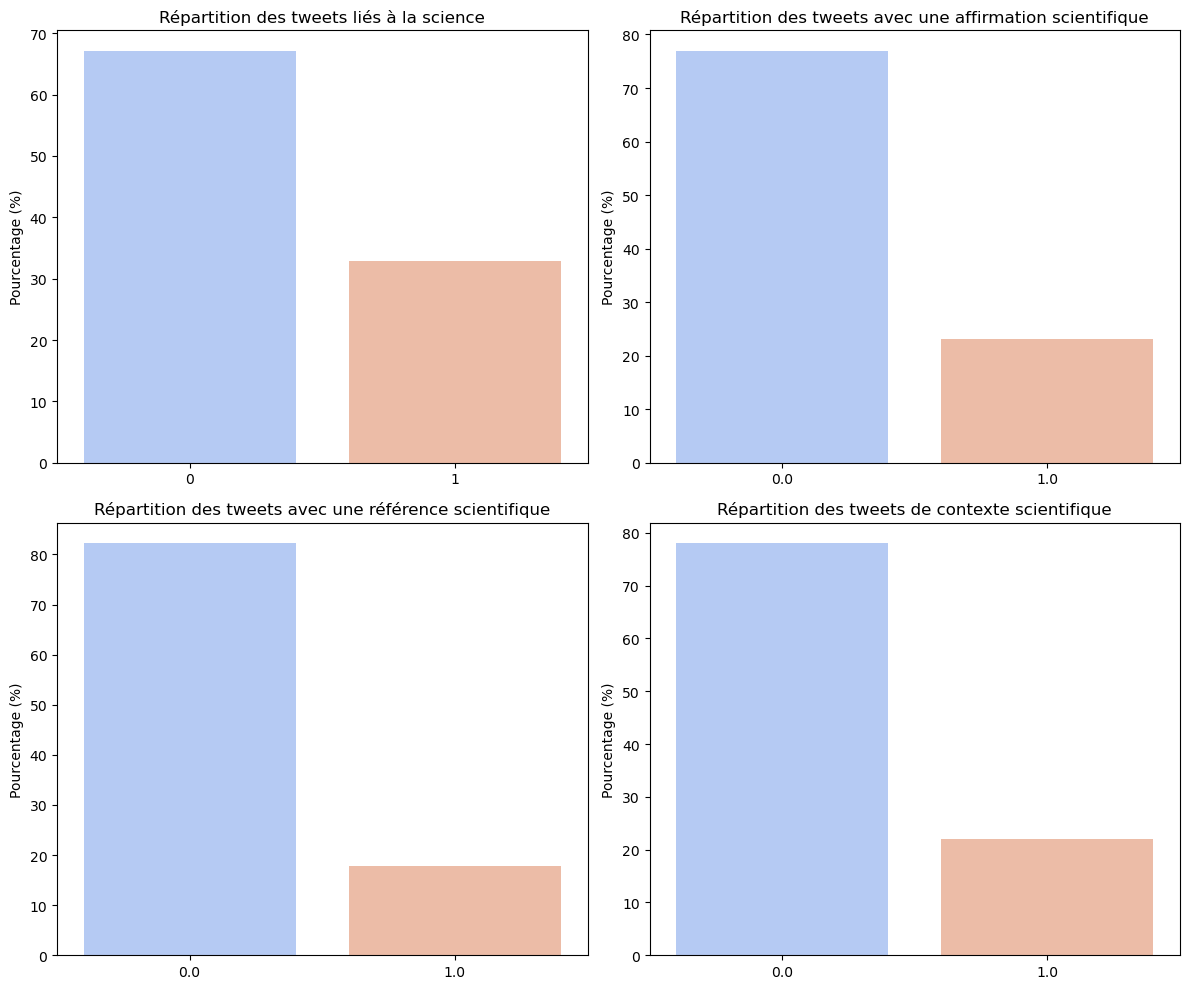

In [3]:
# Définir la figure avec 2 lignes et 2 colonnes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Liste des colonnes à afficher
columns = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']
titles = [
    "Répartition des tweets liés à la science",
    "Répartition des tweets avec une affirmation scientifique",
    "Répartition des tweets avec une référence scientifique",
    "Répartition des tweets de contexte scientifique"
]

# Générer les 4 countplots avec pourcentage
for ax, col, title in zip(axes.flat, columns, titles):
    total = len(df[col])  # Nombre total d'observations
    sns.barplot(
        x=df[col].value_counts(normalize=True).index,  # Valeurs uniques
        y=df[col].value_counts(normalize=True).values * 100,  # Pourcentage
        ax=ax, palette="coolwarm"
    )
    ax.set_title(title)
    ax.set_xlabel("")  # Supprimer les labels des axes X pour plus de lisibilité
    ax.set_ylabel("Pourcentage (%)")

# Ajuster l'espacement
plt.tight_layout()
plt.show()

### Fonction pour traduire en anglais

In [4]:
def translate_to_english(tweet):
    translated = GoogleTranslator(source='auto', target='en').translate(tweet)
    return translated
df['text'] = df['text'].apply(translate_to_english)

### Fonction de pré-traitement

In [5]:
# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
# Charger les données



# Définition des fonctions de prétraitement
def remove_links(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#', '', tweet, flags=re.MULTILINE)

def remove_mentions(tweet):
    return re.sub(r'\@\w+', '', tweet, flags=re.MULTILINE)

def remove_hashtags(tweet):
    return re.sub(r'\#+', '', tweet, flags=re.MULTILINE)

def to_lowercase(tweet):
    return tweet.lower()

def remove_punctuation(tweet):
    return re.sub(r'[^\w\s]', '', tweet)

def remove_stopwords(tweet):
    tokens = word_tokenize(tweet)
    return ' '.join([word for word in tokens if word not in stopwords.words('english')])

def lemmatize_words(tweet):
    tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

def stem_words(tweet):
    tokens = word_tokenize(tweet)
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tokens])


# Liste des transformations possibles
transformations = {
    "remove_links": remove_links,
    "to_lowercase": to_lowercase,
    "remove_punctuation": remove_punctuation,
    "remove_stopwords": remove_stopwords,
    "lemmatize_words": lemmatize_words,
    "remove_mentions": remove_mentions,
    "remove_hashtags": remove_hashtags,
    "stem_words": stem_words
}

# Générer toutes les combinaisons possibles des transformations
all_combinations = []
for i in range(1, len(transformations) + 1):
    all_combinations.extend(itertools.combinations(transformations.keys(), i))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Approche exhaustive


In [6]:
# Import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
import pickle


# === Modèles à tester ===
models = {
    "Régression Logistique": LogisticRegression(class_weight='balanced', max_iter=1000),
    "SVM Linéaire": LinearSVC(class_weight='balanced', max_iter=3000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=5631),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Perceptron Multicouche": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}
# Stocker les résultats
results = []
# Créer une copie du DataFrame original
df_copy2 = df.copy()

# Appliquer un échantillonnage pour équilibrer les classes
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(df_copy2['text'].values.reshape(-1, 1), df_copy2['science_related'])
df_copy2 = pd.DataFrame({'text': X_resampled.flatten(), 'science_related': y_resampled})
# === Boucle principale ===
for i, combo in enumerate(all_combinations):
    df_copy = df_copy2.copy()

    # Appliquer toutes les transformations de la combinaison
    for transform_name in combo:
        df_copy['text'] = df_copy['text'].apply(transformations[transform_name])

    # Données texte + labels
    X = df_copy['text']
    y = df_copy['science_related']

    # TF-IDF
    vectorizer = TfidfVectorizer()
    X_vect = vectorizer.fit_transform(X)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

    # Tester chaque modèle
    for model_name, model in models.items():
        
        copy_model = model
        
        pipeline = make_pipeline(StandardScaler(with_mean=False), copy_model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "combination": combo,
            "model_name": model_name,
            "accuracy": acc,
            "y_test": y_test,
            "y_pred": y_pred
        })
        
        

        print(f"[{i+1}/{len(all_combinations)}] Combo: {combo} | Model: {model_name} | Acc: {acc:.4f}")


[1/255] Combo: ('remove_links',) | Model: Régression Logistique | Acc: 0.8595
[1/255] Combo: ('remove_links',) | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[1/255] Combo: ('remove_links',) | Model: Gradient Boosting | Acc: 0.8366
[1/255] Combo: ('remove_links',) | Model: Decision Tree | Acc: 0.7974
[1/255] Combo: ('remove_links',) | Model: Naive Bayes | Acc: 0.8366
[1/255] Combo: ('remove_links',) | Model: XGBoost | Acc: 0.8627
[1/255] Combo: ('remove_links',) | Model: Perceptron Multicouche | Acc: 0.8301
[2/255] Combo: ('to_lowercase',) | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[2/255] Combo: ('to_lowercase',) | Model: SVM Linéaire | Acc: 0.8595
[2/255] Combo: ('to_lowercase',) | Model: Gradient Boosting | Acc: 0.8595
[2/255] Combo: ('to_lowercase',) | Model: Decision Tree | Acc: 0.8660
[2/255] Combo: ('to_lowercase',) | Model: Naive Bayes | Acc: 0.8399
[2/255] Combo: ('to_lowercase',) | Model: XGBoost | Acc: 0.8922
[2/255] Combo: ('to_lowercase',) | Model: Perceptron Multicouche | Acc: 0.8595
[3/255] Combo: ('remove_punctuation',) | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[3/255] Combo: ('remove_punctuation',) | Model: SVM Linéaire | Acc: 0.8529
[3/255] Combo: ('remove_punctuation',) | Model: Gradient Boosting | Acc: 0.8301
[3/255] Combo: ('remove_punctuation',) | Model: Decision Tree | Acc: 0.8464
[3/255] Combo: ('remove_punctuation',) | Model: Naive Bayes | Acc: 0.8203
[3/255] Combo: ('remove_punctuation',) | Model: XGBoost | Acc: 0.8725
[3/255] Combo: ('remove_punctuation',) | Model: Perceptron Multicouche | Acc: 0.8660
[4/255] Combo: ('remove_stopwords',) | Model: Régression Logistique | Acc: 0.8595
[4/255] Combo: ('remove_stopwords',) | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[4/255] Combo: ('remove_stopwords',) | Model: Gradient Boosting | Acc: 0.8431
[4/255] Combo: ('remove_stopwords',) | Model: Decision Tree | Acc: 0.8529
[4/255] Combo: ('remove_stopwords',) | Model: Naive Bayes | Acc: 0.8366
[4/255] Combo: ('remove_stopwords',) | Model: XGBoost | Acc: 0.8497
[4/255] Combo: ('remove_stopwords',) | Model: Perceptron Multicouche | Acc: 0.8529
[5/255] Combo: ('lemmatize_words',) | Model: Régression Logistique | Acc: 0.8497
[5/255] Combo: ('lemmatize_words',) | Model: SVM Linéaire | Acc: 0.8366


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[5/255] Combo: ('lemmatize_words',) | Model: Gradient Boosting | Acc: 0.8595
[5/255] Combo: ('lemmatize_words',) | Model: Decision Tree | Acc: 0.8595
[5/255] Combo: ('lemmatize_words',) | Model: Naive Bayes | Acc: 0.8431
[5/255] Combo: ('lemmatize_words',) | Model: XGBoost | Acc: 0.9052
[5/255] Combo: ('lemmatize_words',) | Model: Perceptron Multicouche | Acc: 0.8660
[6/255] Combo: ('remove_mentions',) | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[6/255] Combo: ('remove_mentions',) | Model: SVM Linéaire | Acc: 0.8824
[6/255] Combo: ('remove_mentions',) | Model: Gradient Boosting | Acc: 0.8562
[6/255] Combo: ('remove_mentions',) | Model: Decision Tree | Acc: 0.8301
[6/255] Combo: ('remove_mentions',) | Model: Naive Bayes | Acc: 0.8399
[6/255] Combo: ('remove_mentions',) | Model: XGBoost | Acc: 0.8987
[6/255] Combo: ('remove_mentions',) | Model: Perceptron Multicouche | Acc: 0.8333
[7/255] Combo: ('remove_hashtags',) | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[7/255] Combo: ('remove_hashtags',) | Model: SVM Linéaire | Acc: 0.8595
[7/255] Combo: ('remove_hashtags',) | Model: Gradient Boosting | Acc: 0.8464
[7/255] Combo: ('remove_hashtags',) | Model: Decision Tree | Acc: 0.8660
[7/255] Combo: ('remove_hashtags',) | Model: Naive Bayes | Acc: 0.8399
[7/255] Combo: ('remove_hashtags',) | Model: XGBoost | Acc: 0.8922
[7/255] Combo: ('remove_hashtags',) | Model: Perceptron Multicouche | Acc: 0.8627
[8/255] Combo: ('stem_words',) | Model: Régression Logistique | Acc: 0.8725
[8/255] Combo: ('stem_words',) | Model: SVM Linéaire | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[8/255] Combo: ('stem_words',) | Model: Gradient Boosting | Acc: 0.8562
[8/255] Combo: ('stem_words',) | Model: Decision Tree | Acc: 0.8529
[8/255] Combo: ('stem_words',) | Model: Naive Bayes | Acc: 0.8399
[8/255] Combo: ('stem_words',) | Model: XGBoost | Acc: 0.9052
[8/255] Combo: ('stem_words',) | Model: Perceptron Multicouche | Acc: 0.8366
[9/255] Combo: ('remove_links', 'to_lowercase') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[9/255] Combo: ('remove_links', 'to_lowercase') | Model: SVM Linéaire | Acc: 0.8627
[9/255] Combo: ('remove_links', 'to_lowercase') | Model: Gradient Boosting | Acc: 0.8366
[9/255] Combo: ('remove_links', 'to_lowercase') | Model: Decision Tree | Acc: 0.7974
[9/255] Combo: ('remove_links', 'to_lowercase') | Model: Naive Bayes | Acc: 0.8366
[9/255] Combo: ('remove_links', 'to_lowercase') | Model: XGBoost | Acc: 0.8627
[9/255] Combo: ('remove_links', 'to_lowercase') | Model: Perceptron Multicouche | Acc: 0.8399
[10/255] Combo: ('remove_links', 'remove_punctuation') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[10/255] Combo: ('remove_links', 'remove_punctuation') | Model: SVM Linéaire | Acc: 0.8595
[10/255] Combo: ('remove_links', 'remove_punctuation') | Model: Gradient Boosting | Acc: 0.8301
[10/255] Combo: ('remove_links', 'remove_punctuation') | Model: Decision Tree | Acc: 0.8105
[10/255] Combo: ('remove_links', 'remove_punctuation') | Model: Naive Bayes | Acc: 0.8170
[10/255] Combo: ('remove_links', 'remove_punctuation') | Model: XGBoost | Acc: 0.8725
[10/255] Combo: ('remove_links', 'remove_punctuation') | Model: Perceptron Multicouche | Acc: 0.8105
[11/255] Combo: ('remove_links', 'remove_stopwords') | Model: Régression Logistique | Acc: 0.8824
[11/255] Combo: ('remove_links', 'remove_stopwords') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[11/255] Combo: ('remove_links', 'remove_stopwords') | Model: Gradient Boosting | Acc: 0.8170
[11/255] Combo: ('remove_links', 'remove_stopwords') | Model: Decision Tree | Acc: 0.8562
[11/255] Combo: ('remove_links', 'remove_stopwords') | Model: Naive Bayes | Acc: 0.8333
[11/255] Combo: ('remove_links', 'remove_stopwords') | Model: XGBoost | Acc: 0.8431
[11/255] Combo: ('remove_links', 'remove_stopwords') | Model: Perceptron Multicouche | Acc: 0.8464
[12/255] Combo: ('remove_links', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8824


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[12/255] Combo: ('remove_links', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8791
[12/255] Combo: ('remove_links', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8693
[12/255] Combo: ('remove_links', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8170
[12/255] Combo: ('remove_links', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8333
[12/255] Combo: ('remove_links', 'lemmatize_words') | Model: XGBoost | Acc: 0.8725
[12/255] Combo: ('remove_links', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8497
[13/255] Combo: ('remove_links', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[13/255] Combo: ('remove_links', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8627
[13/255] Combo: ('remove_links', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8366
[13/255] Combo: ('remove_links', 'remove_mentions') | Model: Decision Tree | Acc: 0.7974
[13/255] Combo: ('remove_links', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8366
[13/255] Combo: ('remove_links', 'remove_mentions') | Model: XGBoost | Acc: 0.8627
[13/255] Combo: ('remove_links', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8333
[14/255] Combo: ('remove_links', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[14/255] Combo: ('remove_links', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8627
[14/255] Combo: ('remove_links', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8366
[14/255] Combo: ('remove_links', 'remove_hashtags') | Model: Decision Tree | Acc: 0.7974
[14/255] Combo: ('remove_links', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[14/255] Combo: ('remove_links', 'remove_hashtags') | Model: XGBoost | Acc: 0.8627
[14/255] Combo: ('remove_links', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8431
[15/255] Combo: ('remove_links', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[15/255] Combo: ('remove_links', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[15/255] Combo: ('remove_links', 'stem_words') | Model: Gradient Boosting | Acc: 0.8137
[15/255] Combo: ('remove_links', 'stem_words') | Model: Decision Tree | Acc: 0.8301
[15/255] Combo: ('remove_links', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[15/255] Combo: ('remove_links', 'stem_words') | Model: XGBoost | Acc: 0.8824
[15/255] Combo: ('remove_links', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[16/255] Combo: ('to_lowercase', 'remove_punctuation') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[16/255] Combo: ('to_lowercase', 'remove_punctuation') | Model: SVM Linéaire | Acc: 0.8529
[16/255] Combo: ('to_lowercase', 'remove_punctuation') | Model: Gradient Boosting | Acc: 0.8301
[16/255] Combo: ('to_lowercase', 'remove_punctuation') | Model: Decision Tree | Acc: 0.8464
[16/255] Combo: ('to_lowercase', 'remove_punctuation') | Model: Naive Bayes | Acc: 0.8203
[16/255] Combo: ('to_lowercase', 'remove_punctuation') | Model: XGBoost | Acc: 0.8725
[16/255] Combo: ('to_lowercase', 'remove_punctuation') | Model: Perceptron Multicouche | Acc: 0.7941
[17/255] Combo: ('to_lowercase', 'remove_stopwords') | Model: Régression Logistique | Acc: 0.8464
[17/255] Combo: ('to_lowercase', 'remove_stopwords') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[17/255] Combo: ('to_lowercase', 'remove_stopwords') | Model: Gradient Boosting | Acc: 0.8301
[17/255] Combo: ('to_lowercase', 'remove_stopwords') | Model: Decision Tree | Acc: 0.8824
[17/255] Combo: ('to_lowercase', 'remove_stopwords') | Model: Naive Bayes | Acc: 0.8301
[17/255] Combo: ('to_lowercase', 'remove_stopwords') | Model: XGBoost | Acc: 0.8431
[17/255] Combo: ('to_lowercase', 'remove_stopwords') | Model: Perceptron Multicouche | Acc: 0.8562
[18/255] Combo: ('to_lowercase', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8562
[18/255] Combo: ('to_lowercase', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[18/255] Combo: ('to_lowercase', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8464
[18/255] Combo: ('to_lowercase', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8529
[18/255] Combo: ('to_lowercase', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8366
[18/255] Combo: ('to_lowercase', 'lemmatize_words') | Model: XGBoost | Acc: 0.8791
[18/255] Combo: ('to_lowercase', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8562
[19/255] Combo: ('to_lowercase', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[19/255] Combo: ('to_lowercase', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8824
[19/255] Combo: ('to_lowercase', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8497
[19/255] Combo: ('to_lowercase', 'remove_mentions') | Model: Decision Tree | Acc: 0.8301
[19/255] Combo: ('to_lowercase', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8399
[19/255] Combo: ('to_lowercase', 'remove_mentions') | Model: XGBoost | Acc: 0.8987
[19/255] Combo: ('to_lowercase', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8529
[20/255] Combo: ('to_lowercase', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[20/255] Combo: ('to_lowercase', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8595
[20/255] Combo: ('to_lowercase', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8301
[20/255] Combo: ('to_lowercase', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8660
[20/255] Combo: ('to_lowercase', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8399
[20/255] Combo: ('to_lowercase', 'remove_hashtags') | Model: XGBoost | Acc: 0.8922
[20/255] Combo: ('to_lowercase', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8464
[21/255] Combo: ('to_lowercase', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[21/255] Combo: ('to_lowercase', 'stem_words') | Model: SVM Linéaire | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[21/255] Combo: ('to_lowercase', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[21/255] Combo: ('to_lowercase', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[21/255] Combo: ('to_lowercase', 'stem_words') | Model: Naive Bayes | Acc: 0.8431
[21/255] Combo: ('to_lowercase', 'stem_words') | Model: XGBoost | Acc: 0.8987
[21/255] Combo: ('to_lowercase', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8529
[22/255] Combo: ('remove_punctuation', 'remove_stopwords') | Model: Régression Logistique | Acc: 0.8529
[22/255] Combo: ('remove_punctuation', 'remove_stopwords') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[22/255] Combo: ('remove_punctuation', 'remove_stopwords') | Model: Gradient Boosting | Acc: 0.8170
[22/255] Combo: ('remove_punctuation', 'remove_stopwords') | Model: Decision Tree | Acc: 0.8627
[22/255] Combo: ('remove_punctuation', 'remove_stopwords') | Model: Naive Bayes | Acc: 0.8235
[22/255] Combo: ('remove_punctuation', 'remove_stopwords') | Model: XGBoost | Acc: 0.8660
[22/255] Combo: ('remove_punctuation', 'remove_stopwords') | Model: Perceptron Multicouche | Acc: 0.8529
[23/255] Combo: ('remove_punctuation', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8725
[23/255] Combo: ('remove_punctuation', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[23/255] Combo: ('remove_punctuation', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8627
[23/255] Combo: ('remove_punctuation', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8301
[23/255] Combo: ('remove_punctuation', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8366
[23/255] Combo: ('remove_punctuation', 'lemmatize_words') | Model: XGBoost | Acc: 0.8791
[23/255] Combo: ('remove_punctuation', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8497
[24/255] Combo: ('remove_punctuation', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[24/255] Combo: ('remove_punctuation', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8529
[24/255] Combo: ('remove_punctuation', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8301
[24/255] Combo: ('remove_punctuation', 'remove_mentions') | Model: Decision Tree | Acc: 0.8464
[24/255] Combo: ('remove_punctuation', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8203
[24/255] Combo: ('remove_punctuation', 'remove_mentions') | Model: XGBoost | Acc: 0.8725
[24/255] Combo: ('remove_punctuation', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8235
[25/255] Combo: ('remove_punctuation', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[25/255] Combo: ('remove_punctuation', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[25/255] Combo: ('remove_punctuation', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8333
[25/255] Combo: ('remove_punctuation', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[25/255] Combo: ('remove_punctuation', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8203
[25/255] Combo: ('remove_punctuation', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[25/255] Combo: ('remove_punctuation', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8366
[26/255] Combo: ('remove_punctuation', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[26/255] Combo: ('remove_punctuation', 'stem_words') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[26/255] Combo: ('remove_punctuation', 'stem_words') | Model: Gradient Boosting | Acc: 0.8595
[26/255] Combo: ('remove_punctuation', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[26/255] Combo: ('remove_punctuation', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[26/255] Combo: ('remove_punctuation', 'stem_words') | Model: XGBoost | Acc: 0.8922
[26/255] Combo: ('remove_punctuation', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[27/255] Combo: ('remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8595
[27/255] Combo: ('remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[27/255] Combo: ('remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8464
[27/255] Combo: ('remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8464
[27/255] Combo: ('remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8431
[27/255] Combo: ('remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8464
[27/255] Combo: ('remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8399
[28/255] Combo: ('remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8595
[28/255] Combo: ('remove_stopwords', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[28/255] Combo: ('remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8464
[28/255] Combo: ('remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8529
[28/255] Combo: ('remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8366
[28/255] Combo: ('remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8497
[28/255] Combo: ('remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8497
[29/255] Combo: ('remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595
[29/255] Combo: ('remove_stopwords', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[29/255] Combo: ('remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8562
[29/255] Combo: ('remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8529
[29/255] Combo: ('remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[29/255] Combo: ('remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8497
[29/255] Combo: ('remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8562
[30/255] Combo: ('remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[30/255] Combo: ('remove_stopwords', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[30/255] Combo: ('remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8301
[30/255] Combo: ('remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8431
[30/255] Combo: ('remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8399
[30/255] Combo: ('remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8693
[30/255] Combo: ('remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8856
[31/255] Combo: ('lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[31/255] Combo: ('lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8366
[31/255] Combo: ('lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8595
[31/255] Combo: ('lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8595
[31/255] Combo: ('lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8431
[31/255] Combo: ('lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.9052
[31/255] Combo: ('lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8562
[32/255] Combo: ('lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[32/255] Combo: ('lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8366
[32/255] Combo: ('lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8497
[32/255] Combo: ('lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8595
[32/255] Combo: ('lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8431
[32/255] Combo: ('lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.9052
[32/255] Combo: ('lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8693
[33/255] Combo: ('lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[33/255] Combo: ('lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[33/255] Combo: ('lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[33/255] Combo: ('lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[33/255] Combo: ('lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[33/255] Combo: ('lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8922
[33/255] Combo: ('lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[34/255] Combo: ('remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[34/255] Combo: ('remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8824
[34/255] Combo: ('remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8497
[34/255] Combo: ('remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8301
[34/255] Combo: ('remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8399
[34/255] Combo: ('remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8987
[34/255] Combo: ('remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8595
[35/255] Combo: ('remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8922
[35/255] Combo: ('remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[35/255] Combo: ('remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[35/255] Combo: ('remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8431
[35/255] Combo: ('remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[35/255] Combo: ('remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.9052
[35/255] Combo: ('remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[36/255] Combo: ('remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[36/255] Combo: ('remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[36/255] Combo: ('remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[36/255] Combo: ('remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[36/255] Combo: ('remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8399
[36/255] Combo: ('remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.9052
[36/255] Combo: ('remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8660
[37/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[37/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation') | Model: SVM Linéaire | Acc: 0.8595
[37/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation') | Model: Gradient Boosting | Acc: 0.8333
[37/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation') | Model: Decision Tree | Acc: 0.8105
[37/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation') | Model: Naive Bayes | Acc: 0.8170
[37/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation') | Model: XGBoost | Acc: 0.8725
[37/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation') | Model: Perceptron Multicouche | Acc: 0.8170
[38/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords') | Model: Régression Logistique | Acc: 0.8301
[38/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords') | Model: SVM Linéaire | Acc: 0.7190


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[38/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords') | Model: Gradient Boosting | Acc: 0.8137
[38/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords') | Model: Decision Tree | Acc: 0.8203
[38/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords') | Model: Naive Bayes | Acc: 0.8301
[38/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords') | Model: XGBoost | Acc: 0.8268
[38/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords') | Model: Perceptron Multicouche | Acc: 0.8333
[39/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8889
[39/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8824


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[39/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8693
[39/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8007
[39/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8301
[39/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words') | Model: XGBoost | Acc: 0.8627
[39/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8464
[40/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[40/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8627
[40/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8170
[40/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions') | Model: Decision Tree | Acc: 0.7974
[40/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8366
[40/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions') | Model: XGBoost | Acc: 0.8627
[40/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8333
[41/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[41/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8627
[41/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8170
[41/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags') | Model: Decision Tree | Acc: 0.7974
[41/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[41/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags') | Model: XGBoost | Acc: 0.8627
[41/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8431
[42/255] Combo: ('remove_links', 'to_lowercase', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[42/255] Combo: ('remove_links', 'to_lowercase', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[42/255] Combo: ('remove_links', 'to_lowercase', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[42/255] Combo: ('remove_links', 'to_lowercase', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[42/255] Combo: ('remove_links', 'to_lowercase', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[42/255] Combo: ('remove_links', 'to_lowercase', 'stem_words') | Model: XGBoost | Acc: 0.9052
[42/255] Combo: ('remove_links', 'to_lowercase', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[43/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords') | Model: Régression Logistique | Acc: 0.8856
[43/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords') | Model: SVM Linéaire | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[43/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords') | Model: Gradient Boosting | Acc: 0.8235
[43/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords') | Model: Decision Tree | Acc: 0.8529
[43/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords') | Model: Naive Bayes | Acc: 0.8170
[43/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords') | Model: XGBoost | Acc: 0.8562
[43/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords') | Model: Perceptron Multicouche | Acc: 0.8137
[44/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8758
[44/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[44/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8268
[44/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8268
[44/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8268
[44/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words') | Model: XGBoost | Acc: 0.8791
[44/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8464
[45/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[45/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8595
[45/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8464
[45/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions') | Model: Decision Tree | Acc: 0.8105
[45/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8170
[45/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions') | Model: XGBoost | Acc: 0.8725
[45/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8203
[46/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[46/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8595
[46/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8170
[46/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8105
[46/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8170
[46/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[46/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8268
[47/255] Combo: ('remove_links', 'remove_punctuation', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[47/255] Combo: ('remove_links', 'remove_punctuation', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[47/255] Combo: ('remove_links', 'remove_punctuation', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[47/255] Combo: ('remove_links', 'remove_punctuation', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[47/255] Combo: ('remove_links', 'remove_punctuation', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[47/255] Combo: ('remove_links', 'remove_punctuation', 'stem_words') | Model: XGBoost | Acc: 0.8889
[47/255] Combo: ('remove_links', 'remove_punctuation', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[48/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.9020
[48/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[48/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8562
[48/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8693
[48/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8301
[48/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8693
[48/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8693
[49/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8824


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[49/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8725
[49/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8137
[49/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8562
[49/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8333
[49/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8431
[49/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8595
[50/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8824
[50/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[50/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8137
[50/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8562
[50/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8333
[50/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8431
[50/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8366
[51/255] Combo: ('remove_links', 'remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8824
[51/255] Combo: ('remove_links', 'remove_stopwords', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[51/255] Combo: ('remove_links', 'remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[51/255] Combo: ('remove_links', 'remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[51/255] Combo: ('remove_links', 'remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[51/255] Combo: ('remove_links', 'remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8529
[51/255] Combo: ('remove_links', 'remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8693
[52/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8824
[52/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8791


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[52/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8660
[52/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8170
[52/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8333
[52/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8725
[52/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8529
[53/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8824
[53/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8791


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[53/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8660
[53/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8170
[53/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8333
[53/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[53/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[54/255] Combo: ('remove_links', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[54/255] Combo: ('remove_links', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[54/255] Combo: ('remove_links', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[54/255] Combo: ('remove_links', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[54/255] Combo: ('remove_links', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[54/255] Combo: ('remove_links', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8725
[54/255] Combo: ('remove_links', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[55/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[55/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8627
[55/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8366
[55/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.7974
[55/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[55/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8627
[55/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8431
[56/255] Combo: ('remove_links', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[56/255] Combo: ('remove_links', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[56/255] Combo: ('remove_links', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[56/255] Combo: ('remove_links', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8301
[56/255] Combo: ('remove_links', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[56/255] Combo: ('remove_links', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8824
[56/255] Combo: ('remove_links', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[57/255] Combo: ('remove_links', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[57/255] Combo: ('remove_links', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[57/255] Combo: ('remove_links', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8301
[57/255] Combo: ('remove_links', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8301
[57/255] Combo: ('remove_links', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[57/255] Combo: ('remove_links', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8824
[57/255] Combo: ('remove_links', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8431
[58/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Régression Logistique | Acc: 0.8627
[58/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[58/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Gradient Boosting | Acc: 0.8170
[58/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Decision Tree | Acc: 0.8627
[58/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Naive Bayes | Acc: 0.8235
[58/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: XGBoost | Acc: 0.8529
[58/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Perceptron Multicouche | Acc: 0.8497
[59/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8693
[59/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[59/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8431
[59/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8431
[59/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8333
[59/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: XGBoost | Acc: 0.8889
[59/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.7941
[60/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[60/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8529
[60/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8301
[60/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Decision Tree | Acc: 0.8464
[60/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8203
[60/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: XGBoost | Acc: 0.8725
[60/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8333
[61/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[61/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[61/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8301
[61/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[61/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8203
[61/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[61/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[62/255] Combo: ('to_lowercase', 'remove_punctuation', 'stem_words') | Model: Régression Logistique | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[62/255] Combo: ('to_lowercase', 'remove_punctuation', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[62/255] Combo: ('to_lowercase', 'remove_punctuation', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[62/255] Combo: ('to_lowercase', 'remove_punctuation', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[62/255] Combo: ('to_lowercase', 'remove_punctuation', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[62/255] Combo: ('to_lowercase', 'remove_punctuation', 'stem_words') | Model: XGBoost | Acc: 0.8889
[62/255] Combo: ('to_lowercase', 'remove_punctuation', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8366
[63/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8595
[63/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[63/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8366
[63/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8562
[63/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8399
[63/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8562
[63/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8497
[64/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8464
[64/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[64/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8431
[64/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8824
[64/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8301
[64/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8431
[64/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8497
[65/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8464
[65/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[65/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8235
[65/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8824
[65/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[65/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8431
[65/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8529
[66/255] Combo: ('to_lowercase', 'remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[66/255] Combo: ('to_lowercase', 'remove_stopwords', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[66/255] Combo: ('to_lowercase', 'remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[66/255] Combo: ('to_lowercase', 'remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[66/255] Combo: ('to_lowercase', 'remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[66/255] Combo: ('to_lowercase', 'remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8725
[66/255] Combo: ('to_lowercase', 'remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8660
[67/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8562
[67/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[67/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8366
[67/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8529
[67/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8366
[67/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8791
[67/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8660
[68/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[68/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[68/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8464
[68/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8529
[68/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[68/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8791
[68/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8693
[69/255] Combo: ('to_lowercase', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[69/255] Combo: ('to_lowercase', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[69/255] Combo: ('to_lowercase', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8595
[69/255] Combo: ('to_lowercase', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[69/255] Combo: ('to_lowercase', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[69/255] Combo: ('to_lowercase', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.9020
[69/255] Combo: ('to_lowercase', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[70/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[70/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8824
[70/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8497
[70/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8301
[70/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8399
[70/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8987
[70/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8693
[71/255] Combo: ('to_lowercase', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8922
[71/255] Combo: ('to_lowercase', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[71/255] Combo: ('to_lowercase', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[71/255] Combo: ('to_lowercase', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8464
[71/255] Combo: ('to_lowercase', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[71/255] Combo: ('to_lowercase', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.9150
[71/255] Combo: ('to_lowercase', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[72/255] Combo: ('to_lowercase', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[72/255] Combo: ('to_lowercase', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8693
[72/255] Combo: ('to_lowercase', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[72/255] Combo: ('to_lowercase', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[72/255] Combo: ('to_lowercase', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8431
[72/255] Combo: ('to_lowercase', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8987
[72/255] Combo: ('to_lowercase', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[73/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8660
[73/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[73/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8595
[73/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8464
[73/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8366
[73/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8693
[73/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8529
[74/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8529
[74/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[74/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8170
[74/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8627
[74/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8235
[74/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8660
[74/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8497
[75/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8529
[75/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[75/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8137
[75/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8627
[75/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8235
[75/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8660
[75/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8333
[76/255] Combo: ('remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[76/255] Combo: ('remove_punctuation', 'remove_stopwords', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[76/255] Combo: ('remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[76/255] Combo: ('remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[76/255] Combo: ('remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[76/255] Combo: ('remove_punctuation', 'remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8562
[76/255] Combo: ('remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8497
[77/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[77/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8529
[77/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8529
[77/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8301
[77/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8366
[77/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8791
[77/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8595
[78/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8725
[78/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[78/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8627
[78/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8301
[78/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[78/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8791
[78/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[79/255] Combo: ('remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8627
[79/255] Combo: ('remove_punctuation', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[79/255] Combo: ('remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[79/255] Combo: ('remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[79/255] Combo: ('remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[79/255] Combo: ('remove_punctuation', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8725
[79/255] Combo: ('remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8431
[80/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[80/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[80/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8301
[80/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[80/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8203
[80/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[80/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8791
[81/255] Combo: ('remove_punctuation', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[81/255] Combo: ('remove_punctuation', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[81/255] Combo: ('remove_punctuation', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[81/255] Combo: ('remove_punctuation', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[81/255] Combo: ('remove_punctuation', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[81/255] Combo: ('remove_punctuation', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8922
[81/255] Combo: ('remove_punctuation', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8072
[82/255] Combo: ('remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[82/255] Combo: ('remove_punctuation', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[82/255] Combo: ('remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8595
[82/255] Combo: ('remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[82/255] Combo: ('remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[82/255] Combo: ('remove_punctuation', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8922
[82/255] Combo: ('remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8824
[83/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8595
[83/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[83/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8464
[83/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8464
[83/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8431
[83/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8464
[83/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8725
[84/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[84/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[84/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8497
[84/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[84/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8431
[84/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8464
[84/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8824
[85/255] Combo: ('remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[85/255] Combo: ('remove_stopwords', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[85/255] Combo: ('remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[85/255] Combo: ('remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[85/255] Combo: ('remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[85/255] Combo: ('remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8627
[85/255] Combo: ('remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[86/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595
[86/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[86/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8497
[86/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8529
[86/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[86/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8497
[86/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8464
[87/255] Combo: ('remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[87/255] Combo: ('remove_stopwords', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[87/255] Combo: ('remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[87/255] Combo: ('remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8431
[87/255] Combo: ('remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8399
[87/255] Combo: ('remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8693
[87/255] Combo: ('remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8529
[88/255] Combo: ('remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[88/255] Combo: ('remove_stopwords', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[88/255] Combo: ('remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[88/255] Combo: ('remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8431
[88/255] Combo: ('remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8399
[88/255] Combo: ('remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8693
[88/255] Combo: ('remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8758
[89/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[89/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8366
[89/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8595
[89/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8595
[89/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8431
[89/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.9052
[89/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8529
[90/255] Combo: ('lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[90/255] Combo: ('lemmatize_words', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627
[90/255] Combo: ('lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8595
[90/255] Combo: ('lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[90/255] Combo: ('lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[90/255] Combo: ('lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8922
[90/255] Combo: ('lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[91/255] Combo: ('lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[91/255] Combo: ('lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627
[91/255] Combo: ('lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8595
[91/255] Combo: ('lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[91/255] Combo: ('lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[91/255] Combo: ('lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8922
[91/255] Combo: ('lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8399
[92/255] Combo: ('remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8922


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[92/255] Combo: ('remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8693
[92/255] Combo: ('remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[92/255] Combo: ('remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8431
[92/255] Combo: ('remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[92/255] Combo: ('remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.9052
[92/255] Combo: ('remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8693
[93/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Régression Logistique | Acc: 0.8203
[93/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: SVM Linéaire | Acc: 0.7353


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[93/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Gradient Boosting | Acc: 0.8072
[93/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Decision Tree | Acc: 0.8203
[93/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Naive Bayes | Acc: 0.8203
[93/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: XGBoost | Acc: 0.8399
[93/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords') | Model: Perceptron Multicouche | Acc: 0.8235
[94/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8824
[94/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[94/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8431
[94/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8007
[94/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8268
[94/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: XGBoost | Acc: 0.8889
[94/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8464
[95/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[95/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8595
[95/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8301
[95/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Decision Tree | Acc: 0.8105
[95/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8170
[95/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: XGBoost | Acc: 0.8725
[95/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8301
[96/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[96/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8595
[96/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8301
[96/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8105
[96/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8170
[96/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[96/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8431
[97/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[97/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'stem_words') | Model: SVM Linéai

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[97/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[97/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[97/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[97/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'stem_words') | Model: XGBoost | Acc: 0.8987
[97/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[98/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8366
[98/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.7810


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[98/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8529
[98/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8431
[98/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8399
[98/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8529
[98/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8366
[99/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8301
[99/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.7190


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[99/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8137
[99/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8203
[99/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8301
[99/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8268
[99/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8268
[100/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8301
[100/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.7190


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[100/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8137
[100/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8203
[100/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[100/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8268
[100/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8268
[101/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8333
[101/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'stem_words') | Model: SVM Linéaire | Acc: 0.7778


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[101/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[101/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[101/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[101/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8562
[101/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8399
[102/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8889
[102/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8824


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[102/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8693
[102/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8007
[102/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8301
[102/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8627
[102/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8529
[103/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8889
[103/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8824


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[103/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8758
[103/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8007
[103/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[103/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8627
[103/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8366
[104/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[104/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[104/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[104/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[104/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[104/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8987
[104/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[105/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[105/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8627
[105/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8170
[105/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.7974
[105/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[105/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8627
[105/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8464
[106/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[106/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[106/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8301
[106/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[106/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[106/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.9052
[106/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8366
[107/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[107/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[107/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8301
[107/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[107/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[107/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.9052
[107/255] Combo: ('remove_links', 'to_lowercase', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[108/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8987
[108/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[108/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8595
[108/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8464
[108/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8235
[108/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8693
[108/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8627
[109/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8856
[109/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[109/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8235
[109/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8529
[109/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8170
[109/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8562
[109/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8399
[110/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8856
[110/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[110/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8235
[110/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8529
[110/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8170
[110/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8562
[110/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8170
[111/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[111/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[111/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[111/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[111/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[111/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8725
[111/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[112/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8758
[112/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[112/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8301
[112/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8268
[112/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8268
[112/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8791
[112/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8399
[113/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[113/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8758
[113/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8268
[113/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8268
[113/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8268
[113/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8791
[113/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8824
[114/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[114/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', '

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[114/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[114/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[114/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[114/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8791
[114/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8497
[115/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[115/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8595
[115/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8366
[115/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8105
[115/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8170
[115/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[115/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8431
[116/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[116/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', '

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[116/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8137
[116/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[116/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[116/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8889
[116/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8431
[117/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[117/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[117/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8203
[117/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[117/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[117/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8889
[117/255] Combo: ('remove_links', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8366
[118/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.9020
[118/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[118/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8464
[118/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8693
[118/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8301
[118/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8693
[118/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8366
[119/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.9020
[119/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[119/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8464
[119/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8693
[119/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[119/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8693
[119/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[120/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[120/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[120/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8301
[120/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[120/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[120/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8562
[120/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8431
[121/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8824
[121/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[121/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8105
[121/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8562
[121/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8333
[121/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8431
[121/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8333
[122/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8824
[122/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[122/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[122/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[122/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[122/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8529
[122/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8366
[123/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8824
[123/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[123/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[123/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[123/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[123/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[123/255] Combo: ('remove_links', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8366
[124/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8824
[124/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8791


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[124/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8660
[124/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8170
[124/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8333
[124/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[124/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8725
[125/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[125/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[125/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8366
[125/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[125/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[125/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8725
[125/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[126/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[126/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[126/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[126/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[126/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[126/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[126/255] Combo: ('remove_links', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[127/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[127/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[127/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8137
[127/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8301
[127/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[127/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8824
[127/255] Combo: ('remove_links', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[128/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8758
[128/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[128/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8464
[128/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8660
[128/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8366
[128/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8824
[128/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8529
[129/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8627
[129/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[129/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8170
[129/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8627
[129/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8235
[129/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8529
[129/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8627
[130/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627
[130/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[130/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8203
[130/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8627
[130/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8235
[130/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8529
[130/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8464
[131/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[131/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[131/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[131/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[131/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[131/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8529
[131/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8235
[132/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[132/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8562
[132/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8464
[132/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8431
[132/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8333
[132/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8889
[132/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8399
[133/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8693
[133/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_word

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[133/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8595
[133/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8431
[133/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8333
[133/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8889
[133/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[134/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[134/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[134/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[134/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8464
[134/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[134/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8922
[134/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8235
[135/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8497


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[135/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[135/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8399
[135/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[135/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8203
[135/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[135/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8039
[136/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[136/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', '

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[136/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8268
[136/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[136/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[136/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8889
[136/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[137/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[137/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[137/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[137/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[137/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[137/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8889
[137/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[138/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8595
[138/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[138/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8366
[138/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8562
[138/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8399
[138/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8562
[138/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8791
[139/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595
[139/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[139/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8366
[139/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8562
[139/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8399
[139/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8562
[139/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8562
[140/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[140/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[140/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[140/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[140/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[140/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8660
[140/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[141/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8464
[141/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[141/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8235
[141/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8824
[141/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[141/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8431
[141/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[142/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[142/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[142/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[142/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[142/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[142/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8725
[142/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8333
[143/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[143/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[143/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[143/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[143/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[143/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[143/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8693
[144/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[144/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[144/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8464
[144/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8529
[144/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[144/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8791
[144/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8399
[145/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[145/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[145/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[145/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[145/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[145/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.9020
[145/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8660
[146/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[146/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[146/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[146/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[146/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[146/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.9020
[146/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[147/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8922
[147/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[147/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8725
[147/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8464
[147/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[147/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.9150
[147/255] Combo: ('to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8660
[148/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8660
[148/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[148/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8529
[148/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8464
[148/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8366
[148/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8693
[148/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8660
[149/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8660
[149/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[149/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8529
[149/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[149/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[149/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8693
[149/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8529
[150/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[150/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[150/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[150/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[150/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[150/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8562
[150/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8497
[151/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8529
[151/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8431


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[151/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8170
[151/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8627
[151/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8235
[151/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8660
[151/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[152/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[152/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[152/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[152/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[152/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[152/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8562
[152/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[153/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[153/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[153/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[153/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[153/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[153/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[153/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[154/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[154/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529
[154/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8627
[154/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8301
[154/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[154/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8791
[154/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8693
[155/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8627
[155/255] Combo: ('remove_punctuation', 'lemmatize_word

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[155/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[155/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[155/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[155/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8725
[155/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8333
[156/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8627
[156/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[156/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[156/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[156/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[156/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[156/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8105
[157/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[157/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8562


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[157/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[157/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[157/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[157/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8922
[157/255] Combo: ('remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8529
[158/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8595
[158/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8529


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[158/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8399
[158/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[158/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8431
[158/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8464
[158/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8366
[159/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[159/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[159/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[159/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[159/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[159/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8627
[159/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8693
[160/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[160/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[160/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[160/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[160/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[160/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8627
[160/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[161/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[161/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[161/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8366
[161/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8431
[161/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8399
[161/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8693
[161/255] Combo: ('remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8889
[162/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[162/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[162/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[162/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[162/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[162/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8922
[162/255] Combo: ('lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[163/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Régression Logistique | Acc: 0.8399
[163/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: SVM Linéaire | Acc: 0.7680


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[163/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Gradient Boosting | Acc: 0.8627
[163/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Decision Tree | Acc: 0.8660
[163/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Naive Bayes | Acc: 0.8268
[163/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: XGBoost | Acc: 0.8725
[163/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words') | Model: Perceptron Multicouche | Acc: 0.8627
[164/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8203
[164/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[164/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8072
[164/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Decision Tree | Acc: 0.8203
[164/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8203
[164/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: XGBoost | Acc: 0.8399
[164/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8203
[165/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8203
[165/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[165/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8039
[165/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8203
[165/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8203
[165/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: XGBoost | Acc: 0.8399
[165/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8105
[166/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Régression Logistique | Acc: 0.8301
[166/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words'

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[166/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[166/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[166/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[166/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: XGBoost | Acc: 0.8529
[166/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[167/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8824


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[167/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.8758
[167/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8366
[167/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8007
[167/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8268
[167/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8889
[167/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8627
[168/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Mo

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[168/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8758
[168/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8203
[168/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8007
[168/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8268
[168/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8889
[168/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[169/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[169/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[169/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[169/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[169/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8856
[169/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8072
[170/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[170/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8595
[170/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8301
[170/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8105
[170/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8170
[170/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[170/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8399
[171/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[171/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8203
[171/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[171/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[171/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8987
[171/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[172/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[172/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725
[172/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8366
[172/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[172/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[172/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8987
[172/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8268
[173/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[173/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8595
[173/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8431
[173/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8399
[173/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8529
[173/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8529
[174/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8366
[174/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[174/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8464
[174/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8431
[174/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8399
[174/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8529
[174/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8399
[175/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8301
[175/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: SVM Linéai

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[175/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8170
[175/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[175/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[175/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8366
[175/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8366
[176/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8301
[176/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.719

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[176/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8105
[176/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8203
[176/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[176/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8268
[176/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8431
[177/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8333
[177/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: SVM Linéai

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[177/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8203
[177/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[177/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[177/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8562
[177/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[178/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8333
[178/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.7778


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[178/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8366
[178/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[178/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[178/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[178/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8235
[179/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8889


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[179/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8824
[179/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8693
[179/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8007
[179/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[179/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8627
[179/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8529
[180/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[180/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[180/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[180/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[180/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8987
[180/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8366
[181/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[181/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660
[181/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[181/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[181/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[181/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8987
[181/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8497
[182/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[182/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627
[182/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[182/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[182/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[182/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.9052
[182/255] Combo: ('remove_links', 'to_lowercase', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[183/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8987
[18

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[183/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8627
[183/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8464
[183/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8235
[183/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8693
[183/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8660
[184/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8987
[184/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemm

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[184/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8595
[184/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[184/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8235
[184/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8693
[184/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8529
[185/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[185/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[185/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[185/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[185/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[185/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8627
[185/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[186/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8856
[186/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_has

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[186/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8235
[186/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8529
[186/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8170
[186/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8562
[186/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8170
[187/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[187/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_me

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[187/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[187/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[187/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[187/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8725
[187/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[188/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[188/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[188/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[188/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[188/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[188/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[188/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8170
[189/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8758


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[189/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8758
[189/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8301
[189/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8268
[189/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8268
[189/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8791
[189/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8399
[190/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 's

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[190/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8758
[190/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[190/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[190/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[190/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8791
[190/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8235
[191/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régressio

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[191/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[191/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[191/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[191/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8791
[191/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8399
[192/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693
[192/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[192/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8105
[192/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[192/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[192/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8889
[192/255] Combo: ('remove_links', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8333
[193/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.9020
[193/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | M

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[193/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8497
[193/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8693
[193/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8301
[193/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8693
[193/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8333
[194/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[194/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words'

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[194/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[194/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[194/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[194/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8562
[194/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[195/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8791
[195/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire |

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[195/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8366
[195/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[195/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[195/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[195/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8431
[196/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8824
[196/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire |

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[196/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[196/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[196/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[196/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[196/255] Combo: ('remove_links', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8399
[197/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8725
[197/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | A

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[197/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[197/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[197/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[197/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[197/255] Combo: ('remove_links', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[198/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Régression Logistique | Acc: 0.8758
[198/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: SVM

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[198/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8595
[198/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8660
[198/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8366
[198/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8824
[198/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0.8268
[199/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8758
[199/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemm

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[199/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8595
[199/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8660
[199/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[199/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8824
[199/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[200/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Acc: 0.8562
[200/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[200/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[200/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[200/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[200/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8529
[200/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8693
[201/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8627
[201/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_has

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[201/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8105
[201/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8627
[201/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8235
[201/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8529
[201/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8301
[202/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[202/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_me

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[202/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[202/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[202/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[202/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8529
[202/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[203/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[203/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[203/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[203/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[203/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[203/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[203/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[204/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[204/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: SVM Linéaire | Acc: 0.8562
[204/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8529
[204/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8431
[204/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8333
[204/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8889
[204/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8464
[205/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 's

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[205/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[205/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8366
[205/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8464
[205/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[205/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8922
[205/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8693
[206/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régressio

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[206/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[206/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[206/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8464
[206/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[206/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8922
[206/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8333
[207/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régressio

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[207/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[207/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[207/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[207/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[207/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8889
[207/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[208/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régres

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[208/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8366
[208/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8562
[208/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8399
[208/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8562
[208/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8595
[209/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[209/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words'

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[209/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[209/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[209/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[209/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8660
[209/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[210/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[210/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire |

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[210/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[210/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[210/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[210/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8660
[210/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8693
[211/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[211/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire |

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[211/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[211/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[211/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8366
[211/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[211/255] Combo: ('to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8399
[212/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[212/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[212/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8562
[212/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[212/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[212/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.9020
[212/255] Combo: ('to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8431
[213/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logisti

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[213/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8562
[213/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[213/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[213/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8693
[213/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8660
[214/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8660
[214/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmati

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[214/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[214/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[214/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[214/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8562
[214/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[215/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8660


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[215/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[215/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[215/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[215/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[215/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[215/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[216/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'ste

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[216/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8366
[216/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[216/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[216/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[216/255] Combo: ('remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[217/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8627


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[217/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8529
[217/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[217/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8399
[217/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[217/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[217/255] Combo: ('remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[218/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words')

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[218/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8660
[218/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[218/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[218/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[218/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8627
[218/255] Combo: ('remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8497
[219/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_m

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[219/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: SVM Linéaire | Acc: 0.7680
[219/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Gradient Boosting | Acc: 0.8529
[219/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Decision Tree | Acc: 0.8660
[219/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Naive Bayes | Acc: 0.8268
[219/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: XGBoost | Acc: 0.8725
[219/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions') | Model: Perceptron Multicouche | Acc: 0

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[220/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8464
[220/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8660
[220/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8268
[220/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[220/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8595
[221/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Régression Logistique | Ac

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[221/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[221/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[221/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[221/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: XGBoost | Acc: 0.8431
[221/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8529
[222/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8203
[222/255] 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[222/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8039
[222/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8203
[222/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8203
[222/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8399
[222/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8203
[223/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Ac

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[223/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[223/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[223/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[223/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8529
[223/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[224/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8301
[224/255] Combo

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[224/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[224/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[224/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[224/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[224/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8203
[225/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8824
[225/255] C

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[225/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8431
[225/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8007
[225/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8268
[225/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8889
[225/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8595
[226/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[226/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: SVM Linéaire | Acc: 0.8758
[226/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[226/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[226/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[226/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8856
[226/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[227/255] Combo: ('remove_link

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[227/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8595
[227/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[227/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[227/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8856
[227/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8333
[228/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8693


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[228/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8725
[228/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[228/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8203
[228/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[228/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8987
[228/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8627
[229/255] Combo: ('remove_link

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[229/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8464
[229/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8431
[229/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8399
[229/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8529
[229/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8529
[230/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régression Logistique | Acc: 0.8301
[230/255

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[230/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8235
[230/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[230/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[230/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8366
[230/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[231/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8301
[231/255] Combo: ('remove_links',

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[231/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.7974
[231/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[231/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[231/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8366
[231/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[232/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8333
[232/255] Combo: ('remove_links',

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[232/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8137
[232/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8529
[232/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8301
[232/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[232/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8529
[233/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.8758
[233/255] Combo: ('remove_links', 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[233/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[233/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8660
[233/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[233/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8987
[233/255] Combo: ('remove_links', 'to_lowercase', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8170
[234/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8987
[234/255] Combo: ('remove_l

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[234/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8595
[234/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8464
[234/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8235
[234/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8693
[234/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8627
[235/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régressi

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[235/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[235/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[235/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[235/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8627
[235/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8529
[236/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.87

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[236/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[236/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[236/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[236/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8627
[236/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[237/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.87

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[237/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[237/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[237/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[237/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8725
[237/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8562
[238/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.866

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[238/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8758
[238/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[238/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8268
[238/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[238/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8791
[238/255] Combo: ('remove_links', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8595
[239/255] Co

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[239/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[239/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8562
[239/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[239/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[239/255] Combo: ('remove_links', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8660
[240/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Régression Logistique | Acc: 0.8758
[240/25

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[240/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8497
[240/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8660
[240/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8366
[240/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8824
[240/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8497
[241/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Régressi

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[241/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[241/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[241/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[241/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8529
[241/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8529
[242/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.85

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[242/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8562
[242/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[242/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[242/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[242/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[242/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8725
[243/2

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[243/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[243/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8627
[243/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8333
[243/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[243/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[244/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Régression Logistique | Acc: 0.866

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[244/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[244/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[244/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8464
[244/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[244/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8922
[244/255] Combo: ('to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8497
[245/255] Co

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[245/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8627
[245/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8399
[245/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[245/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[245/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8660
[245/255] Combo: ('to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[246/255] Combo: ('remov

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[246/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: SVM Linéaire | Acc: 0.8595
[246/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[246/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8725
[246/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[246/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8562
[246/255] Combo: ('remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | 

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[247/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Gradient Boosting | Acc: 0.8464
[247/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Decision Tree | Acc: 0.8660
[247/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Naive Bayes | Acc: 0.8268
[247/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: XGBoost | Acc: 0.8725
[247/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags') | Model: Perceptron Multicouche | Acc: 0.8268
[248/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctua

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[248/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[248/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[248/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[248/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: XGBoost | Acc: 0.8431
[248/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[249/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords'

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[249/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8529
[249/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[249/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[249/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8431
[249/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[250/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords'

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[250/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[250/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[250/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8268
[250/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[250/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8497
[251/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words',

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[251/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8431
[251/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8366
[251/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8137
[251/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8856
[251/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8464
[252/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remov

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[252/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8333
[252/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8758
[252/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[252/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8366
[252/255] Combo: ('remove_links', 'to_lowercase', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[253/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_me

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[253/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8497
[253/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8497
[253/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8170
[253/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8627
[253/255] Combo: ('remove_links', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8301
[254/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords',

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[254/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[254/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[254/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8235
[254/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8529
[254/255] Combo: ('to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.8007
[255/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 're

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[255/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Gradient Boosting | Acc: 0.8464
[255/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Decision Tree | Acc: 0.8595
[255/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Naive Bayes | Acc: 0.8203
[255/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: XGBoost | Acc: 0.8431
[255/255] Combo: ('remove_links', 'to_lowercase', 'remove_punctuation', 'remove_stopwords', 'lemmatize_words', 'remove_mentions', 'remove_hashtags', 'stem_words') | Model: Perceptron Multicouche | Acc: 0.

### Affichage des meilleurs combinaisons par modèle

In [7]:
# Convertir les résultats en DataFrame pour manipulation facile
results_df = pd.DataFrame(results)

# Trouver la meilleure combinaison pour chaque modèle
best_per_model = results_df.loc[results_df.groupby("model_name")["accuracy"].idxmax()]

# Afficher joliment
print("\n=== Meilleures combinaisons par modèle ===")

best_model = best_per_model.sort_values(by="accuracy", ascending=False);


# Créer un DataFrame à partir des trois colonnes affichées précédemment
summary_df = pd.DataFrame({
    "Combination": best_model['combination'],
    "Model Name": best_model['model_name'],
    "Accuracy": best_model['accuracy']
})

# Afficher le DataFrame
display(summary_df)


# Convertir le DataFrame en tableau formaté
#print(tabulate(best_model, headers="keys", tablefmt="pretty", showindex=False))





=== Meilleures combinaisons par modèle ===


,Combination,Model Name,Accuracy
495,"(to_lowercase, remove_mentions, stem_words)",XGBoost,0.915033
329,"(remove_links, remove_stopwords, lemmatize_words)",Régression Logistique,0.901961
1126,"(remove_stopwords, remove_mentions, remove_has...",Perceptron Multicouche,0.888889
115,"(to_lowercase, remove_stopwords)",Decision Tree,0.882353
36,"(remove_mentions,)",SVM Linéaire,0.882353
716,"(remove_links, to_lowercase, lemmatize_words, ...",Gradient Boosting,0.875817
32,"(lemmatize_words,)",Naive Bayes,0.843137


### Affichage des stats du meilleurs modèle


Meilleur résultat :
Modèle     : XGBoost
Combo      : ('to_lowercase', 'remove_mentions', 'stem_words')
Accuracy   : 0.9150

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       147
           1       0.91      0.93      0.92       159

    accuracy                           0.92       306
   macro avg       0.92      0.91      0.91       306
weighted avg       0.92      0.92      0.91       306

Matrice de confusion :


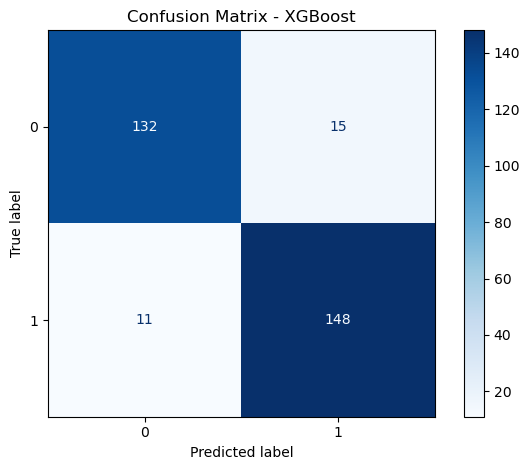

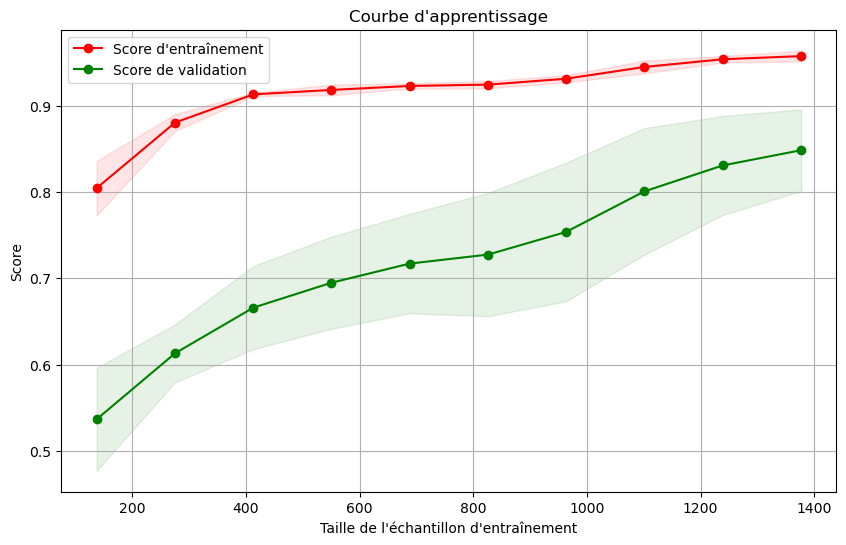

--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.8464
Recall: 0.8464
Precision: 0.8464


In [8]:
# ------------------ Affichage du meilleur modèle ------------------

results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df["accuracy"].idxmax()]

print("\nMeilleur résultat :")
print(f"Modèle     : {best_result['model_name']}")
print(f"Combo      : {best_result['combination']}")
print(f"Accuracy   : {best_result['accuracy']:.4f}")

# Rapport + matrice de confusion
print("\nClassification Report:")
print(classification_report(best_result["y_test"], best_result["y_pred"]))

print("Matrice de confusion :")
cm = confusion_matrix(best_result["y_test"], best_result["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {best_result['model_name']}")
plt.tight_layout()
plt.show()

from sklearn.model_selection import learning_curve

# Récupérer le modèle correspondant au meilleur résultat
model_name = best_result["model_name"]
model = models[model_name]  # Utiliser le dictionnaire 'models' pour obtenir l'objet du modèle

# Calculer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
	model,  # Passer l'objet du modèle ici
	vectorizer.fit_transform(df_copy['text']),  # Données d'entrée
	df_copy['science_related'],  # Labels
	cv=10,  # Nombre de folds pour la validation croisée
	scoring='accuracy',  # Métrique d'évaluation
	n_jobs=-1,  # Utiliser tous les cœurs disponibles
	train_sizes=np.linspace(0.1, 1.0, 10)  # Proportions des données d'entraînement
)

# Moyenne et écart-type des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")

plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

# Calculate additional statistics
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Display the statistics
print("--------------------------------------------------------")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Nous pouvons remarquer deux principaux éléments. Tout d'abord les résulats qui sont particulièrement bon lors de l'entrainement ce qui nous permet de dire de qu'il y a probablement des biais ou des sur-apprentisage. De plus, nous pouvons voire un écart-type lors de la validation important, cela est probablement des pré-traitement qui sont incorrect. En effet, nous pouvons voire que les pré-traitements n'inclut pas la suppression des stopwords. Cependant, il est a noté que l'écart entre le score de validation et le score d'apprentisage montre que le modèle doit avoir un léger sur-apprentisage. L'accuracy est relativement bon cependant le F1-score, le Recall et la précision sont clairement en moins bon ce qui nous montre que notre modèle n'est très bon.

In [53]:

def fitting_with_scaffold(model, X_resampled, y_resampled,name1,name2):
    # Configuration des K-Folds
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Validation croisée
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

    # Calculer la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_resampled, y_resampled, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Moyenne et écart-type des scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracer la courbe d'apprentissage
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")

    plt.title("Courbe d'apprentissage")
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

    # Affichage des résultats de la validation croisée
    print(f"Scores par pli : {cv_scores}")
    print(f"Score moyen    : {cv_scores.mean():.4f}")
    print(f"Écart-type     : {cv_scores.std():.4f}")

    # Étape 7 : Entraînement final et évaluation
    final_cm = np.zeros((2, 2), dtype=int)

    for train_index, test_index in kfold.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_index.tolist()], X_resampled[test_index.tolist()]
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Ajouter à la matrice de confusion globale
        cm = confusion_matrix(y_test, y_pred)
        final_cm += cm

    # Afficher la matrice de confusion finale
    disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=[name1, name2])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Matrice de confusion globale")
    plt.show()
    print(f"Accuracy: {cv_scores.mean():.4f}")
    # Calculate additional statistics
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Display the statistics
    print("--------------------------------------------------------")
    print(f"precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    if hasattr(vectorizer, 'get_feature_names_out'):
        feature_names = vectorizer.get_feature_names_out()
    else:
        raise ValueError("The vectorizer object must be fitted before calling get_feature_names_out().")
    
    # Afficher les mots les plus importants par classe

    # Calculer le chi2 pour chaque mot
    chi2_scores, p_values = chi2(X_resampled, y_resampled)

    # Obtenir les mots les plus importants pour chaque classe
    feature_names = vectorizer.get_feature_names_out()
    important_words = pd.DataFrame({
        'Word': feature_names,
        'Chi2': chi2_scores
    }).sort_values(by='Chi2', ascending=False)

    # Afficher les 10 mots les plus importants pour chaque classe
    print("\n=== Mots les plus importants par classe ===")
    display(important_words.head(10))

### Afin d'être plus rapide dans notre dévellopement, nous allons prendre un model et ainsi que des modifications ayant de "bon résultat"

Nous avions précédement identifier des models ainsi que des transformations prometteusent. Cependant, la quantité de calcle

In [49]:

df_copy = df.copy()
# model = LogisticRegression(class_weight='balanced', max_iter=1000)


combo = ["remove_links","stem_words","remove_stopwords","lemmatize_words","to_lowercase"]

for transform_name in combo:
        df_copy['text'] = df_copy['text'].apply(transformations[transform_name])




        
X = df_copy['text']
y = df_copy['science_related']
# Étape 4 : Vectorisation avec TF-IDF
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)


# Étape 5 : Équilibrage des classes avec RandomOverSampler

# Use ADASYN for oversampling
#ros = ADASYN(random_state=42,sampling_strategy=0.75438596499)
#ros = ADASYN(random_state=42,sampling_strategy=0.8)
# Adjust the sampling_strategy to ensure new samples can be generated
ros = ADASYN(random_state=42, sampling_strategy='minority')

#ros = ADASYN(random_state=42,sampling_strategy=0.75438596499)
X_resampled, y_resampled = ros.fit_resample(X_vect, y)
#X_resampled, y_resampled = X_vect, y

#### Refaisons l'entrainement du même modèle en modifiant les données afin de determiner si on arrive à obtenir un meilleur résultat


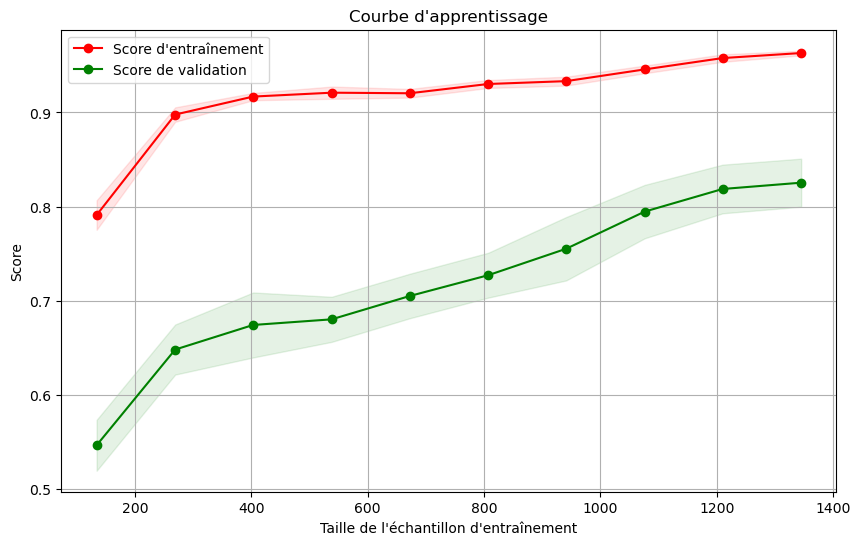

Scores par pli : [0.83333333 0.82       0.82       0.84       0.81333333 0.7852349
 0.83892617 0.87919463 0.82550336 0.86577181]
Score moyen    : 0.8321
Écart-type     : 0.0252


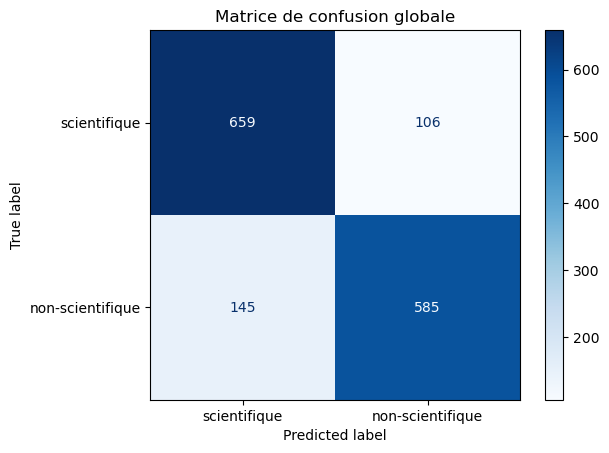

Accuracy: 0.8321
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.8656
Recall: 0.8658

=== Mots les plus importants par classe ===


,Word,Chi2
4297,stop,20.474488
2065,health,10.721450
4376,support,9.952101
4331,studi,8.644930
3787,research,7.926223
758,cancer,6.213550
3725,reduc,5.941771
665,brain,5.762879
3846,risk,5.222012
3966,scienc,5.074026


In [11]:
from sklearn.preprocessing import LabelEncoder



# Update the model and fit
model = XGBClassifier(eval_metric='logloss')
fitting_with_scaffold(model, X_resampled, y_resampled,"scientifique","non-scientifique")

On peut voire un net amélioration. Grâce à l'utilisation de k-fold, de la crosse validation et de donnée mieux traiter on a réussit à diminuer grandement l'ecart-type. De plus, les résultats en validation ne tendent à rejoindre les résulats d'entrainement ce qui montre que le modèle ce généralise. Cependant, il doit y avoir un sur-apprentissage en entrainement car la courbe d'entrainement possède de très bon résultat avec un écart-type presque inexistant à partir 400 tweet d'entrainement. Cependant on peut noter un bonne amélioration

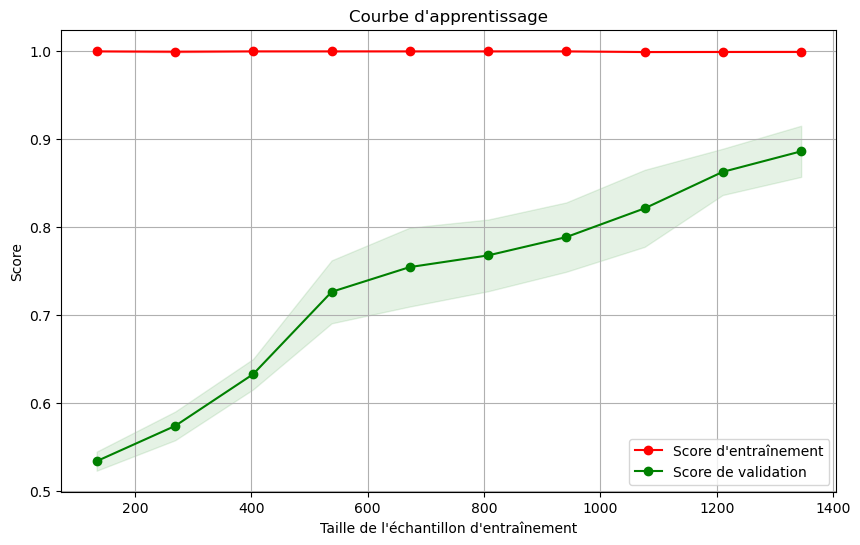

Scores par pli : [0.86666667 0.85333333 0.90666667 0.91333333 0.86666667 0.89261745
 0.8590604  0.95302013 0.86577181 0.88590604]
Score moyen    : 0.8863
Écart-type     : 0.0294


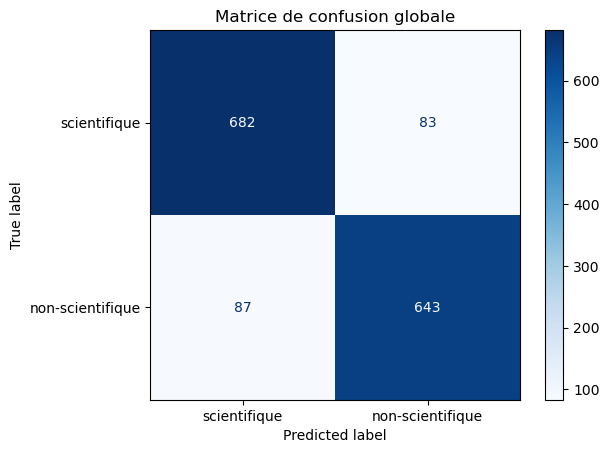

Accuracy: 0.8863
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.8859
Recall: 0.8859

=== Mots les plus importants par classe ===


,Word,Chi2
4297,stop,20.474488
2065,health,10.721450
4376,support,9.952101
4331,studi,8.644930
3787,research,7.926223
758,cancer,6.213550
3725,reduc,5.941771
665,brain,5.762879
3846,risk,5.222012
3966,scienc,5.074026


In [12]:
#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.01))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
#model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
#model = XGBClassifier(eval_metric='logloss')
#model = SVC(kernel='linear', probability=True, random_state=42)
#model = SVC(kernel='linear', probability=True, random_state=42, C=0.01)
fitting_with_scaffold(model,X_resampled,y_resampled,"scientifique","non-scientifique")




Ici on voit que le modèle apprend entièrement les données, cependant le modéle semble bien ce généraliser mais étant donné le sur-apprentisage, il n'apprend donc pas de manière robuste. Etant donné que l'on a utiliser random Forest, cela est peut-être du à la profondeux de l'arbre qui entraîne la mémorisation des données. L'ensemble des scores (Accuracy, F1-score, Recall, precision) sont bon mais cela est induit pas le sur-apprentisage

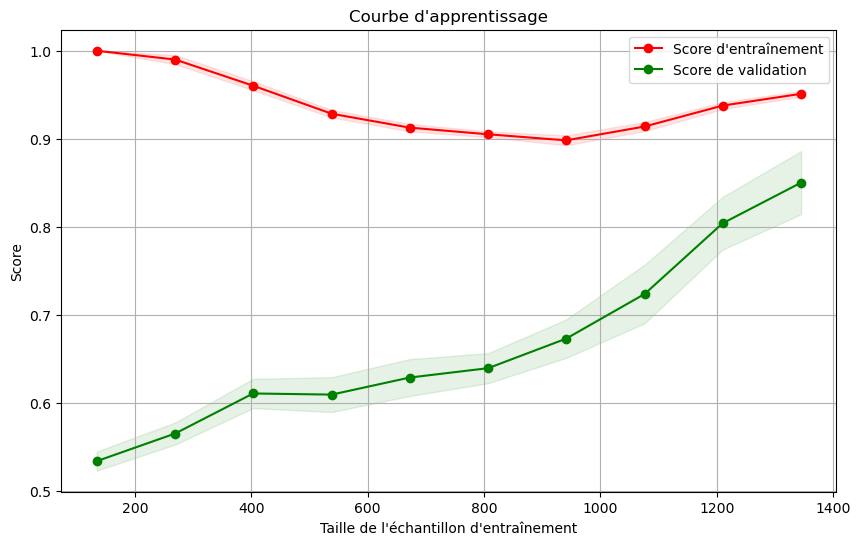

Scores par pli : [0.80666667 0.85333333 0.86       0.86       0.82       0.83892617
 0.79865772 0.91275168 0.83892617 0.89261745]
Score moyen    : 0.8482
Écart-type     : 0.0340


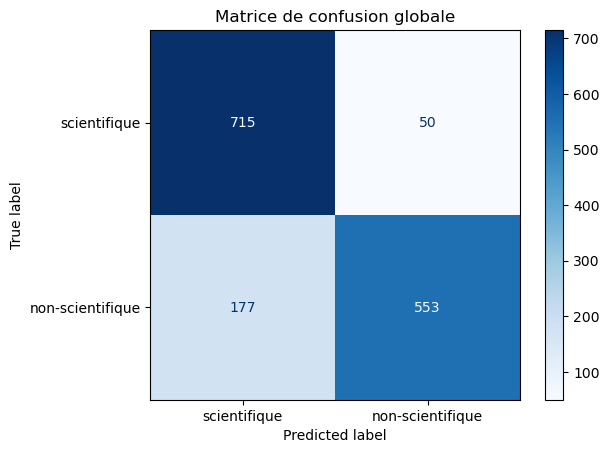

Accuracy: 0.8482
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.8922
Recall: 0.8926

=== Mots les plus importants par classe ===


,Word,Chi2
4297,stop,20.474488
2065,health,10.721450
4376,support,9.952101
4331,studi,8.644930
3787,research,7.926223
758,cancer,6.213550
3725,reduc,5.941771
665,brain,5.762879
3846,risk,5.222012
3966,scienc,5.074026


In [13]:

#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.01))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=42)
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
#model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
#model = XGBClassifier(eval_metric='logloss')
#model = SVC(kernel='linear', probability=True, random_state=42)
#model = SVC(kernel='linear', probability=True, random_state=42, C=0.01)
fitting_with_scaffold(model,X_resampled,y_resampled,"scientifique","non-scientifique")



Ici on a encore un mémorisation des données par le model. Cependant ici l'on voit plus le fonctionnement typique de randomForest à la différence d'un sur-apprentisage évident. La matrice de confusion nous montre que les tweets scientifique on beaucoup de faux négatif ce qui montre que notre modèle pourrait être encore améliorer, on a remarqué qu'en augmentant la profondeur de l'arbre on diminue le nombre de faux positif, cependant la mémorisation des données augmentent. Les autre scores sont bon est cohérents entre eux ce qui montre que le modèle est efficace sans montrer de contradiction flagrantes( beaucoup de faux positif... ).

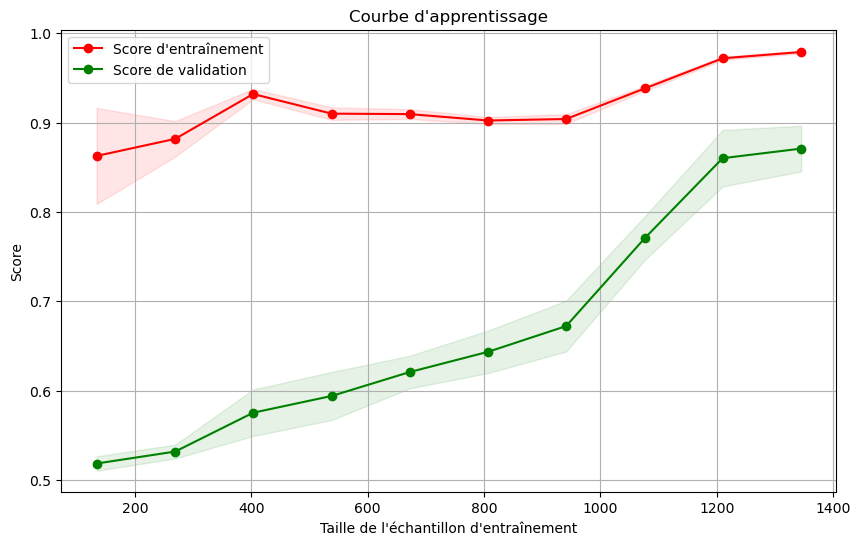

Scores par pli : [0.86       0.84666667 0.89333333 0.89333333 0.86       0.88590604
 0.84563758 0.91946309 0.82550336 0.87248322]
Score moyen    : 0.8702
Écart-type     : 0.0267


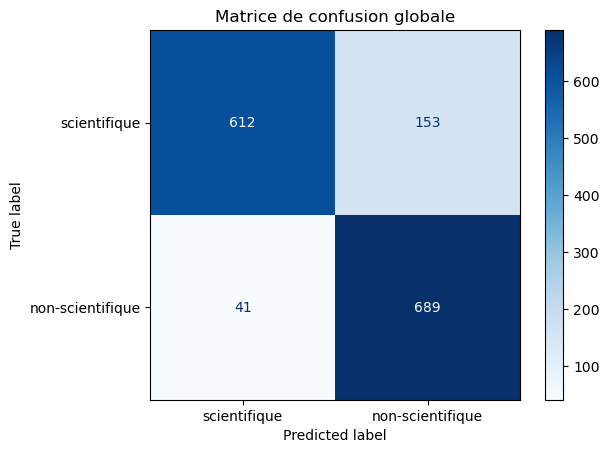

Accuracy: 0.8702
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.8717
Recall: 0.8725

=== Mots les plus importants par classe ===


,Word,Chi2
4297,stop,20.474488
2065,health,10.721450
4376,support,9.952101
4331,studi,8.644930
3787,research,7.926223
758,cancer,6.213550
3725,reduc,5.941771
665,brain,5.762879
3846,risk,5.222012
3966,scienc,5.074026


In [14]:

#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.01))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
#model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
#model = XGBClassifier(eval_metric='logloss')
#model = SVC(kernel='linear', probability=True, random_state=42)
#model = SVC(kernel='linear', probability=True, random_state=42, C=0.01)

model = MultinomialNB()
fitting_with_scaffold(model,X_resampled,y_resampled,"scientifique","non-scientifique")

Désormais, on vois de bon résultat avec une bonne généralisation et on a pas de sur-apprentisage. De plus le score d'entrainement et de validation de rapproche ce qui montre la généralisation du modèle. Enfin les résulats ne sont bon sans être trop bon. Le score d'entrainement est très élever mais cela ne tant que à la fin au sur-apprentisage. De plus le modéle semble bien ce généraliser en plus d'être relativement fiable grace à c'est bon score

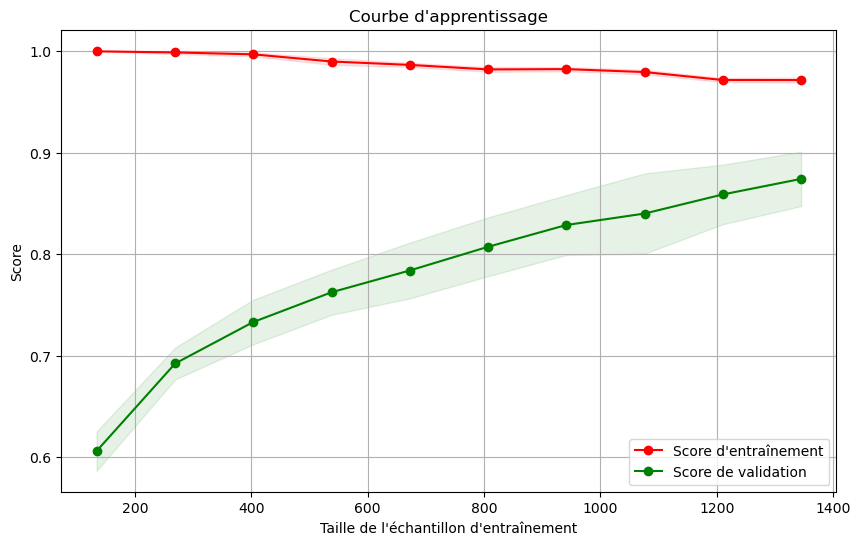

Scores par pli : [0.82       0.88       0.90666667 0.88666667 0.85333333 0.8590604
 0.85234899 0.91275168 0.89261745 0.87248322]
Score moyen    : 0.8736
Écart-type     : 0.0267


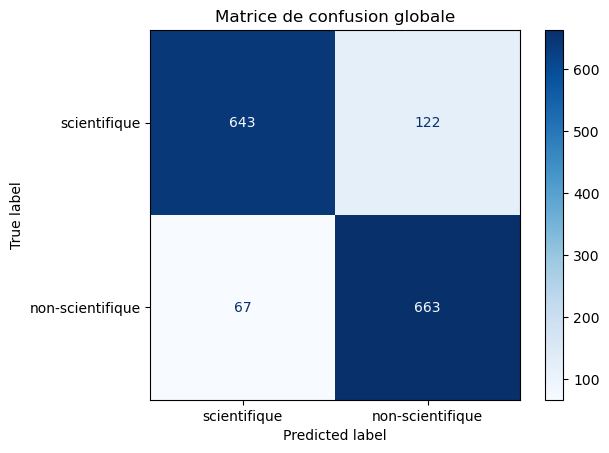

Accuracy: 0.8736
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.8724
Recall: 0.8725

=== Mots les plus importants par classe ===


,Word,Chi2
4297,stop,20.474488
2065,health,10.721450
4376,support,9.952101
4331,studi,8.644930
3787,research,7.926223
758,cancer,6.213550
3725,reduc,5.941771
665,brain,5.762879
3846,risk,5.222012
3966,scienc,5.074026


In [15]:

#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.01))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
#model = XGBClassifier(eval_metric='logloss')
#model = SVC(kernel='linear', probability=True, random_state=42)
#model = SVC(kernel='linear', probability=True, random_state=42, C=0.01)


fitting_with_scaffold(model,X_resampled,y_resampled,"scientifique","non-scientifique")

Avec logistique régréssion, on voir désormais qu'il y a de la mémorisation des données au début que cela ce dissipe avec la quantité de données traité. Cependant les résultats reste trop élever pour exclure le sur-apprentisage. De plus il est à noté que le score de validation augmente et il est fort probable que ce derniers rejoigne le score de validation. Cependant pour cela il faudrait bien plus de donnée. Le modèle est plus éfficace que random forest car nous utilisons plus les hyper-paramètre. De plus la véctorisation que l'on a choisit est adapté à Logistique régression

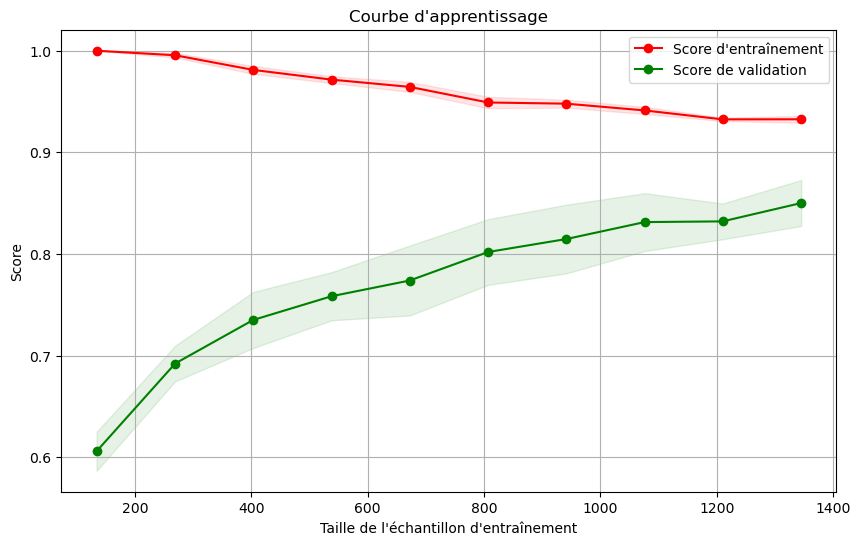

Scores par pli : [0.82       0.82666667 0.87333333 0.89333333 0.84666667 0.83892617
 0.83221477 0.86577181 0.86577181 0.85234899]
Score moyen    : 0.8515
Écart-type     : 0.0219


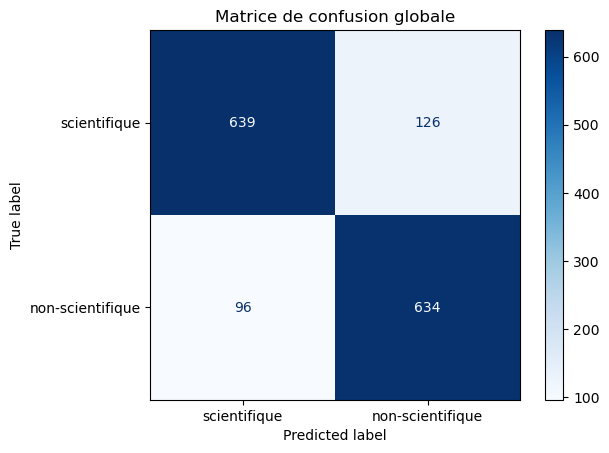

Accuracy: 0.8515
--------------------------------------------------------
precision: 0.8527
F1-Score: 0.8524
Recall: 0.8523

=== Mots les plus importants par classe ===


,Word,Chi2
4297,stop,20.474488
2065,health,10.721450
4376,support,9.952101
4331,studi,8.644930
3787,research,7.926223
758,cancer,6.213550
3725,reduc,5.941771
665,brain,5.762879
3846,risk,5.222012
3966,scienc,5.074026


In [54]:

#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.01))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.0125)
#model = XGBClassifier(eval_metric='logloss')
#model = SVC(kernel='linear', probability=True, random_state=42)
#model = SVC(kernel='linear', probability=True, random_state=42, C=0.01)


fitting_with_scaffold(model,X_resampled,y_resampled,"scientifique","non-scientifique")

## Séparation en 2 classes : (CLAIM et REF) vs CONTEXT

Dans cette partie visant à séparer en deux classes (CLAIM et REF) vs CONTEXT les tweets, on ne s'intéresse qu'aux tweets scientifiques, le dataset utilisé n'a donc aucun tweets non scientifique

Tout d'abord on va réunir les CLAIM et REF dans un nouvelle colonne nommé label. Nous avons décider  de considérer qu'un tweet CLAIM,REFERENCE et CONTEXT sera donc bi-classé.

In [182]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

task2_results= []

# Étape 1 : préparer les données
sci_df = df[df['science_related'] == 1].copy()
task2_df = sci_df.copy()

task2_df = task2_df[task2_df['science_related'] == 1]
task2_df['claim&ref'] = task2_df[['scientific_claim', 'scientific_reference']].max(axis=1) 

task2_df = task2_df[~((task2_df['claim&ref'] == 1) & (task2_df['scientific_context'] == 1))]

display(task2_df)

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context,claim&ref
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0,1.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0,1.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0,1.0
7,9,334282732085587968,Can playing more games improve lives and save ...,1,1.0,0.0,0.0,1.0
14,16,344256820552011777,@RepCohen @SenAlexander @SenBobCorker pls supp...,1,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1109,1226,1318574643771510786,@Jubair22 My question is how many of these dea...,1,1.0,0.0,0.0,1.0
1112,1229,1320058294896033798,The COVID-19 pandemic is not over. Incorrect i...,1,1.0,0.0,0.0,1.0
1130,1249,1338450113765789699,This looks like a great opportunity to get res...,1,0.0,0.0,1.0,0.0
1131,1250,1338483958397480972,Highly prestigious and competitive awards fund...,1,0.0,0.0,1.0,0.0


On affiche la répartition des classes context et la nouvelle classe label

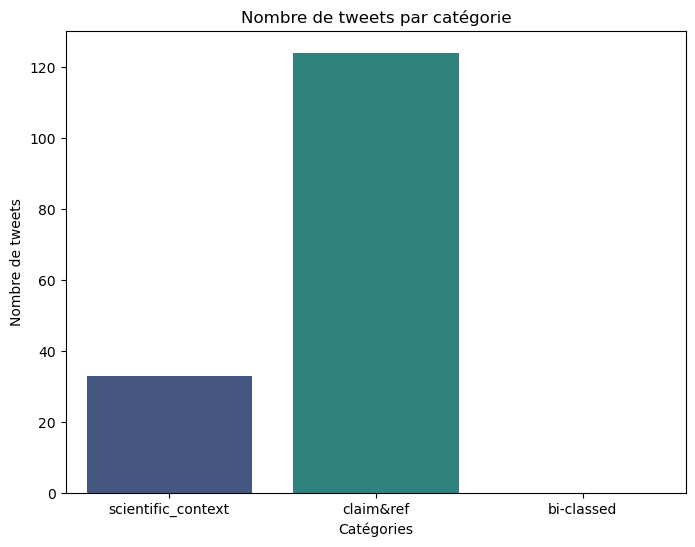

In [183]:
# Calculer les nombres
count_scientific_context = task2_df['scientific_context'].sum()
count_label = task2_df['claim&ref'].sum()
count_bi_classed = task2_df[(task2_df['scientific_context'] == 1) & (task2_df['claim&ref'] == 1)].shape[0]

# Préparer les données pour le graphique
categories = ['scientific_context', 'claim&ref', 'bi-classed']
counts = [count_scientific_context, count_label, count_bi_classed]

# Créer le graphique
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts, palette="viridis")
plt.title("Nombre de tweets par catégorie")
plt.ylabel("Nombre de tweets")
plt.xlabel("Catégories")
plt.show()

On voit qu'il y a un déséquilibre important entre scientific_context et claim&ref. On va considérer dans un premier temps les tweets bi-classé (bi classed) non juste affiché à titre indicatif.

## Equilibrage de scientifs_context et claim&ref

In [166]:
# Étape 1 : Filtrer les données pour la catégorie SCI
sci_df = df[df['science_related'] == 1].copy()


combo = ["remove_links", "remove_stopwords", "lemmatize_words", "stem_words","stem_words"]

for transformation in combo:
    if transformation in transformations:
        sci_df['text'] = sci_df['text'].apply(transformations[transformation])
    else:
        print(f"Warning: {transformation} is not a valid transformation function.")

# Étape 2 : Créer une nouvelle colonne pour les classes {CLAIM, REF} vs {CONTEXT}
sci_df['label'] = sci_df[['scientific_claim', 'scientific_reference']].max(axis=1)

# Étape intermédiaire : Réduire la taille de sci_df en retirant 100 lignes aléatoires
#sci_df = sci_df.sample(n=len(sci_df) - 200, random_state=42).reset_index(drop=True)
# Étape 3 : Préparer les données
X = sci_df['text']
y = sci_df[['label', 'scientific_context']]

# Étape 4 : Vectorisation avec TF-IDF
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

In [167]:
def fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2):
    # Configuration des K-Folds
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Validation croisée
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

    # Calculer la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_resampled, y_resampled, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Moyenne et écart-type des scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Tracer la courbe d'apprentissage
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
    
    plt.title("Courbe d'apprentissage")
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    # Affichage des résultats de la validation croisée
    print(f"Scores par pli : {cv_scores}")
    print(f"Score moyen    : {cv_scores.mean():.4f}")
    print(f"Écart-type     : {cv_scores.std():.4f}")

    # Étape 7 : Entraînement final et évaluation
    final_cm = np.zeros((2, 2), dtype=int)

    for train_index, test_index in kfold.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_index.tolist()], X_resampled[test_index.tolist()]
        y_resampled = pd.Series(y_resampled)
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Ajouter à la matrice de confusion globale
        cm = confusion_matrix(y_test, y_pred)
        final_cm += cm

    # Afficher la matrice de confusion finale
    disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=[name1, name2])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Matrice de confusion globale")
    plt.show()
    print(f"Accuracy: {cv_scores.mean():.4f}")
    # Calculate additional statistics
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Display the statistics
    print("--------------------------------------------------------")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    if hasattr(vectorizer, 'get_feature_names_out'):
        feature_names = vectorizer.get_feature_names_out()
    else:
        raise ValueError("The vectorizer object must be fitted before calling get_feature_names_out().")
    
    # Afficher les mots les plus importants par classe

    # Calculer le chi2 pour chaque mot
    chi2_scores, p_values = chi2(X_resampled, y_resampled)

    # Obtenir les mots les plus importants pour chaque classe
    feature_names = vectorizer.get_feature_names_out()
    important_words = pd.DataFrame({
        'Word': feature_names,
        'Chi2': chi2_scores
    }).sort_values(by='Chi2', ascending=False)

    # Afficher les 10 mots les plus importants pour chaque classe
    print("\n=== Mots les plus importants par classe ===")
    display(important_words.head(10))

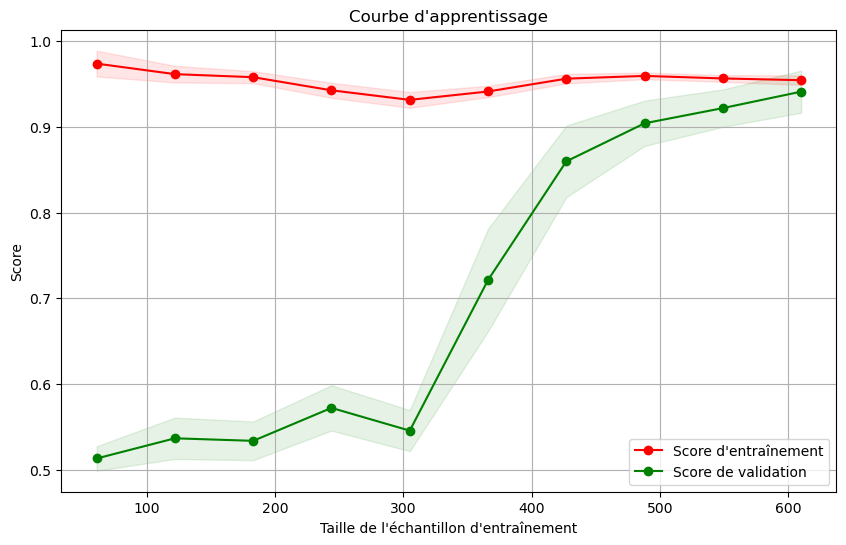

Scores par pli : [0.98529412 0.92647059 0.92647059 0.92647059 0.95588235 0.92647059
 0.92647059 0.91176471 0.94029851 0.98507463]
Score moyen    : 0.9411
Écart-type     : 0.0246


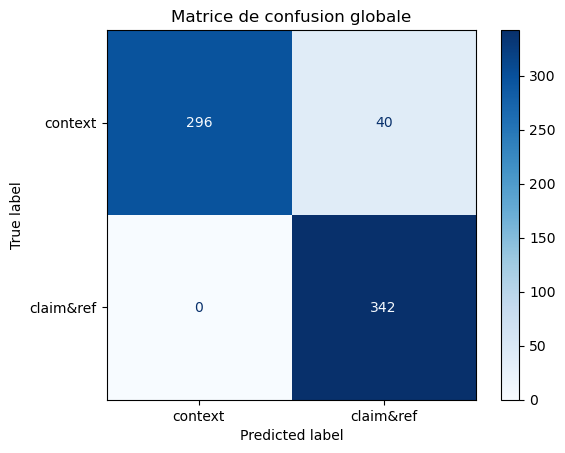

Accuracy: 0.9411
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.9851
Recall: 0.9851

=== Mots les plus importants par classe ===


,Word,Chi2
2006,support,13.890610
1745,research,13.632788
171,april,11.081523
1814,scienc,11.066689
851,fund,10.835433
892,grant,10.110876
1055,institut,7.768934
1205,lupu,7.237413
216,award,7.027253
1653,publicsector,6.984470


In [168]:



    # Étape 5 : Équilibrage des classes avec RandomOverSampler


    # Use ADASYN for oversampling
    #ros = ADASYN(random_state=42,sampling_strategy=0.75438596499)
    #ros = ADASYN(random_state=42,sampling_strategy=0.8)


    # Encode the target variable into a single column
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y['label'])  # Use the 'label' column as the target

    # Adjust the sampling_strategy to ensure new samples can be generated
    ros = ADASYN(random_state=42, sampling_strategy='minority')

    # Apply ADASYN oversampling
    X_resampled, y_resampled_encoded = ros.fit_resample(X_vect, y_encoded)

    # Decode the labels back to their original format
    y_resampled = label_encoder.inverse_transform(y_resampled_encoded)





    #model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.01))
    #model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.0009))
    model = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42,min_samples_split=2))
    #model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
    #model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    #model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    #model = XGBClassifier(eval_metric='logloss')
    #model = SVC(kernel='linear', probability=True, random_state=42)
    #model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42,C=0.092))
    # Configuration des K-Folds
    #fitting_with_scaffold(model,X_resampled,y_resampled,"context","claim&ref")
    name1 = "context"
    name2 ="claim&ref"
    
    fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2)

    

### Under-sampling

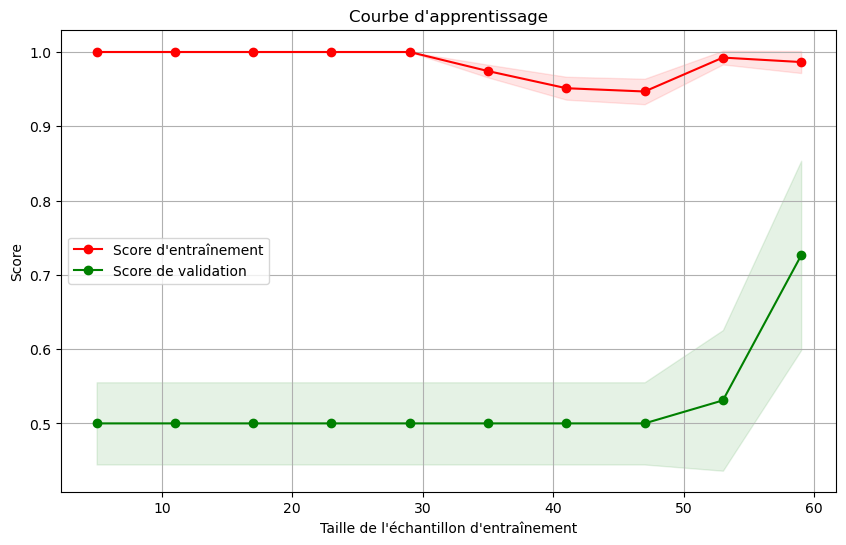

Scores par pli : [0.57142857 0.71428571 0.85714286 1.         0.71428571 0.57142857
 0.5        0.83333333 0.66666667 0.66666667]
Score moyen    : 0.7095
Écart-type     : 0.1440


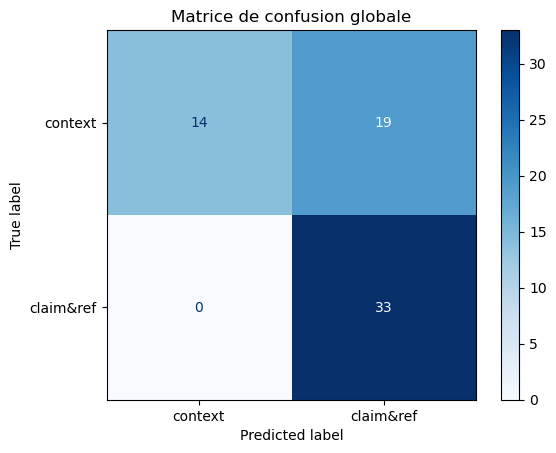

Accuracy: 0.7095
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.6250
Recall: 0.6667

=== Mots les plus importants par classe ===


,Word,Chi2
1814,scienc,2.185110
1745,research,1.927701
2006,support,1.744049
1530,perfect,0.991960
171,april,0.915635
1030,increa,0.848998
1876,show,0.800673
975,how,0.785760
892,grant,0.772419
851,fund,0.761871


In [169]:

from imblearn.under_sampling import RandomUnderSampler

# Filtrer pour conserver une centaine de lignes équilibrées
rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# Utiliser uniquement la colonne 'label' comme cible
X_resampled, y_resampled = rus.fit_resample(X_vect, y['label'])

# Modèle choisi : Régression Logistique
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42,C=0.001))

#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.001))
#model = XGBClassifier(eval_metric='logloss')
#model = OneVsRestClassifier(LogisticRegression())
#model = SVC(kernel='linear', probability=True, random_state=42)
name1 = "context"
name2 ="claim&ref"
    
fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2)

Tactique hybride (under-sampling puis équilibrage avec de l'over-sampling)

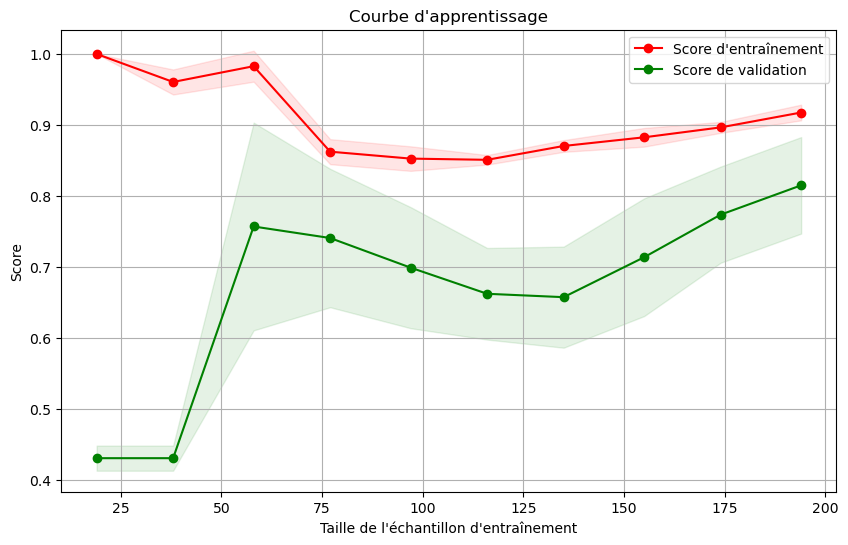

Scores par pli : [0.72727273 0.72727273 0.90909091 0.86363636 0.77272727 0.86363636
 0.9047619  0.76190476 0.80952381 0.85714286]
Score moyen    : 0.8197
Écart-type     : 0.0657


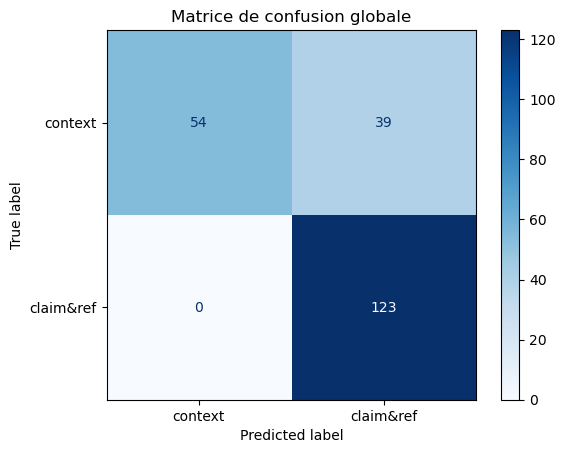

Accuracy: 0.8197
--------------------------------------------------------
precision: 0.8857
F1-Score: 0.8508
Recall: 0.8571

=== Mots les plus importants par classe ===


,Word,Chi2
171,april,5.688873
2006,support,4.319918
1814,scienc,4.295587
1745,research,3.637859
892,grant,3.545842
1860,shape,3.313079
1205,lupu,3.141965
851,fund,2.976055
1446,on,2.729823
465,confer,2.727601


In [185]:
# Filtrer pour conserver une centaine de lignes équilibrées
#rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# Extract the 'label' column as the target
y_single = y['label']

# Apply RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=100 / len(y_single))
X_resampled, y_resampled = rus.fit_resample(X_vect, y_single)

# Apply ADASYN
ros = ADASYN(random_state=42, sampling_strategy=0.75438596499)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)



# Modèle choisi : Régression Logistique

#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.00125))
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

#model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.00125)
#model = XGBClassifier(eval_metric='logloss')
#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42,C=0.001))
# Configuration des K-Folds
name1 = "context"
name2 ="claim&ref"
fitting_with_scaffold(model,X_resampled,y_resampled,name1,name2)   
#fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2)

### Test en conservant les bi-classés

In [171]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

task2_results= []

# Étape 1 : préparer les données
sci_df = df[df['science_related'] == 1].copy()
task2_df = sci_df.copy()

task2_df = task2_df[task2_df['science_related'] == 1]
task2_df['claim&ref'] = task2_df[['scientific_claim', 'scientific_reference']].max(axis=1) 

#task2_df = task2_df[~((task2_df['claim&ref'] == 1) & (task2_df['scientific_context'] == 1))]

display(task2_df)

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context,claim&ref
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0,1.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0,1.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0,1.0
6,8,333266791960809472,“Traffic Jam” In Brain’s Neurons Could Be Caus...,1,1.0,1.0,1.0,1.0
7,9,334282732085587968,Can playing more games improve lives and save ...,1,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
1128,1247,1336903053362954241,Three systematic reviews & the WHO contradict ...,1,0.0,1.0,1.0,1.0
1130,1249,1338450113765789699,This looks like a great opportunity to get res...,1,0.0,0.0,1.0,0.0
1131,1250,1338483958397480972,Highly prestigious and competitive awards fund...,1,0.0,0.0,1.0,0.0
1134,1253,1339398314563792900,"Vestislav Apostolov, David M. J. Calderbank, E...",1,0.0,1.0,1.0,1.0


On affiche la répartition des classes context et la nouvelle classe label

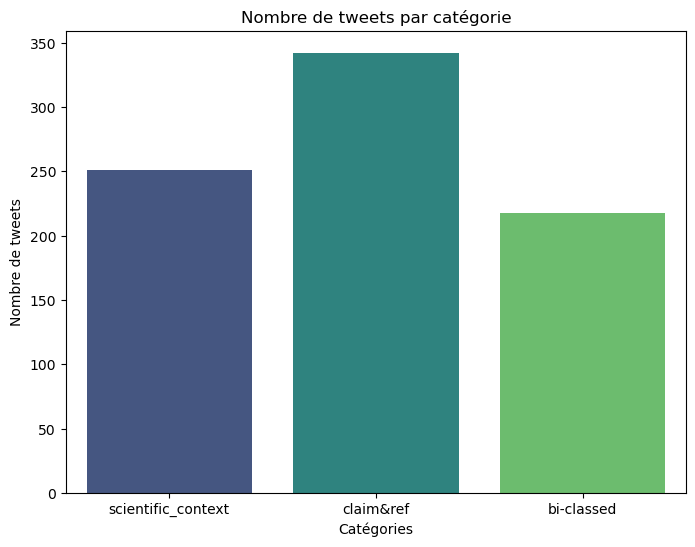

In [172]:
# Calculer les nombres
count_scientific_context = task2_df['scientific_context'].sum()
count_label = task2_df['claim&ref'].sum()
count_bi_classed = task2_df[(task2_df['scientific_context'] == 1) & (task2_df['claim&ref'] == 1)].shape[0]

# Préparer les données pour le graphique
categories = ['scientific_context', 'claim&ref', 'bi-classed']
counts = [count_scientific_context, count_label, count_bi_classed]

# Créer le graphique
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts, palette="viridis")
plt.title("Nombre de tweets par catégorie")
plt.ylabel("Nombre de tweets")
plt.xlabel("Catégories")
plt.show()

On voit qu'il y a un déséquilibre important entre scientific_context et claim&ref. On va considérer dans un premier temps les tweets bi-classé (bi classed) non juste affiché à titre indicatif.

## Equilibrage de scientifs_context et claim&ref

In [173]:
# Étape 1 : Filtrer les données pour la catégorie SCI
sci_df = df[df['science_related'] == 1].copy()


combo = ["remove_links", "remove_stopwords", "lemmatize_words", "stem_words","stem_words"]

for transformation in combo:
    if transformation in transformations:
        sci_df['text'] = sci_df['text'].apply(transformations[transformation])
    else:
        print(f"Warning: {transformation} is not a valid transformation function.")

# Étape 2 : Créer une nouvelle colonne pour les classes {CLAIM, REF} vs {CONTEXT}
sci_df['label'] = sci_df[['scientific_claim', 'scientific_reference']].max(axis=1)

# Étape intermédiaire : Réduire la taille de sci_df en retirant 100 lignes aléatoires
#sci_df = sci_df.sample(n=len(sci_df) - 200, random_state=42).reset_index(drop=True)
# Étape 3 : Préparer les données
X = sci_df['text']
y = sci_df[['label', 'scientific_context']]

# Étape 4 : Vectorisation avec TF-IDF
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

In [174]:
def fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2):
    # Configuration des K-Folds
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Validation croisée
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

    # Calculer la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_resampled, y_resampled, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Moyenne et écart-type des scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Tracer la courbe d'apprentissage
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
    
    plt.title("Courbe d'apprentissage")
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    # Affichage des résultats de la validation croisée
    print(f"Scores par pli : {cv_scores}")
    print(f"Score moyen    : {cv_scores.mean():.4f}")
    print(f"Écart-type     : {cv_scores.std():.4f}")

    # Étape 7 : Entraînement final et évaluation
    final_cm = np.zeros((2, 2), dtype=int)

    for train_index, test_index in kfold.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_index.tolist()], X_resampled[test_index.tolist()]
        y_resampled = pd.Series(y_resampled)
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Ajouter à la matrice de confusion globale
        cm = confusion_matrix(y_test, y_pred)
        final_cm += cm

    # Afficher la matrice de confusion finale
    disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=[name1, name2])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Matrice de confusion globale")
    plt.show()
    print(f"Accuracy: {cv_scores.mean():.4f}")
    # Calculate additional statistics
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Display the statistics
    print("--------------------------------------------------------")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    if hasattr(vectorizer, 'get_feature_names_out'):
        feature_names = vectorizer.get_feature_names_out()
    else:
        raise ValueError("The vectorizer object must be fitted before calling get_feature_names_out().")
    
    # Afficher les mots les plus importants par classe

    # Calculer le chi2 pour chaque mot
    chi2_scores, p_values = chi2(X_resampled, y_resampled)

    # Obtenir les mots les plus importants pour chaque classe
    feature_names = vectorizer.get_feature_names_out()
    important_words = pd.DataFrame({
        'Word': feature_names,
        'Chi2': chi2_scores
    }).sort_values(by='Chi2', ascending=False)

    # Afficher les 10 mots les plus importants pour chaque classe
    print("\n=== Mots les plus importants par classe ===")
    display(important_words.head(10))

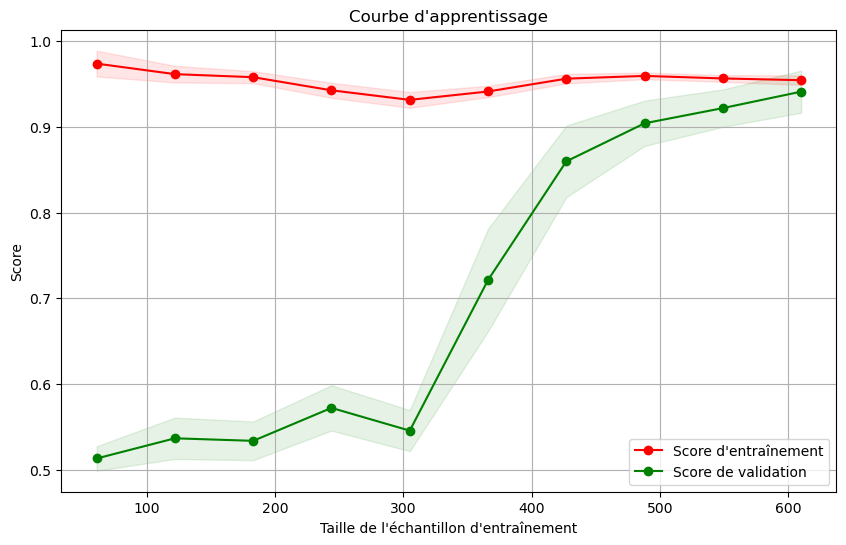

Scores par pli : [0.98529412 0.92647059 0.92647059 0.92647059 0.95588235 0.92647059
 0.92647059 0.91176471 0.94029851 0.98507463]
Score moyen    : 0.9411
Écart-type     : 0.0246


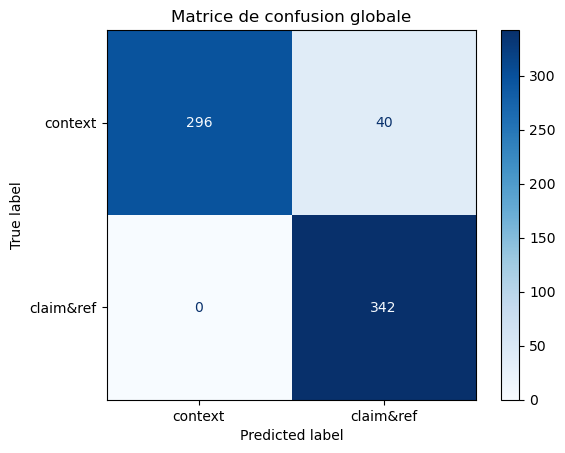

Accuracy: 0.9411
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.9851
Recall: 0.9851

=== Mots les plus importants par classe ===


,Word,Chi2
2006,support,13.890610
1745,research,13.632788
171,april,11.081523
1814,scienc,11.066689
851,fund,10.835433
892,grant,10.110876
1055,institut,7.768934
1205,lupu,7.237413
216,award,7.027253
1653,publicsector,6.984470


In [175]:



    # Étape 5 : Équilibrage des classes avec RandomOverSampler


    # Use ADASYN for oversampling
    #ros = ADASYN(random_state=42,sampling_strategy=0.75438596499)
    #ros = ADASYN(random_state=42,sampling_strategy=0.8)


    # Encode the target variable into a single column
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y['label'])  # Use the 'label' column as the target

    # Adjust the sampling_strategy to ensure new samples can be generated
    ros = ADASYN(random_state=42, sampling_strategy='minority')

    # Apply ADASYN oversampling
    X_resampled, y_resampled_encoded = ros.fit_resample(X_vect, y_encoded)

    # Decode the labels back to their original format
    y_resampled = label_encoder.inverse_transform(y_resampled_encoded)





    #model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.01))
    #model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.0009))
    model = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42,min_samples_split=2))
    #model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.000125))
    #model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    #model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    #model = XGBClassifier(eval_metric='logloss')
    #model = SVC(kernel='linear', probability=True, random_state=42)
    #model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42,C=0.092))
    # Configuration des K-Folds
    #fitting_with_scaffold(model,X_resampled,y_resampled,"context","claim&ref")
    name1 = "context"
    name2 ="claim&ref"
    
    fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2)

    

### Under-sampling

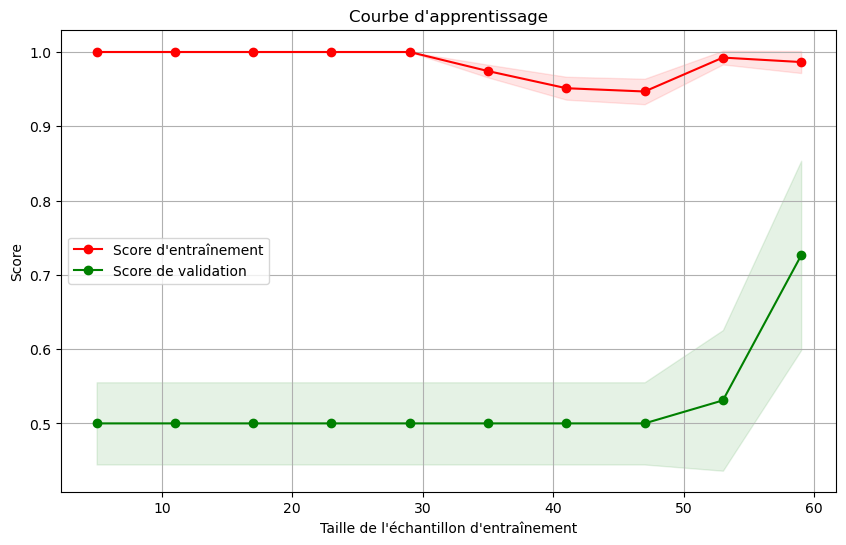

Scores par pli : [0.57142857 0.71428571 0.85714286 1.         0.71428571 0.57142857
 0.5        0.83333333 0.66666667 0.66666667]
Score moyen    : 0.7095
Écart-type     : 0.1440


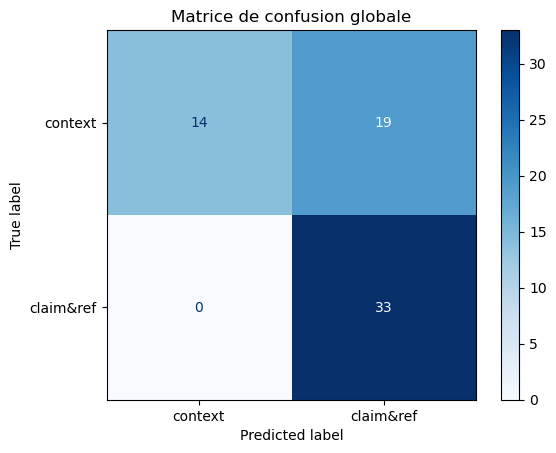

Accuracy: 0.7095
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.6250
Recall: 0.6667

=== Mots les plus importants par classe ===


,Word,Chi2
1814,scienc,2.185110
1745,research,1.927701
2006,support,1.744049
1530,perfect,0.991960
171,april,0.915635
1030,increa,0.848998
1876,show,0.800673
975,how,0.785760
892,grant,0.772419
851,fund,0.761871


In [176]:

from imblearn.under_sampling import RandomUnderSampler

# Filtrer pour conserver une centaine de lignes équilibrées
rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# Utiliser uniquement la colonne 'label' comme cible
X_resampled, y_resampled = rus.fit_resample(X_vect, y['label'])

# Modèle choisi : Régression Logistique
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42,C=0.001))

#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.001))
#model = XGBClassifier(eval_metric='logloss')
#model = OneVsRestClassifier(LogisticRegression())
#model = SVC(kernel='linear', probability=True, random_state=42)
name1 = "context"
name2 ="claim&ref"
    
fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2)

Tactique hybride (under-sampling puis équilibrage avec de l'over-sampling)

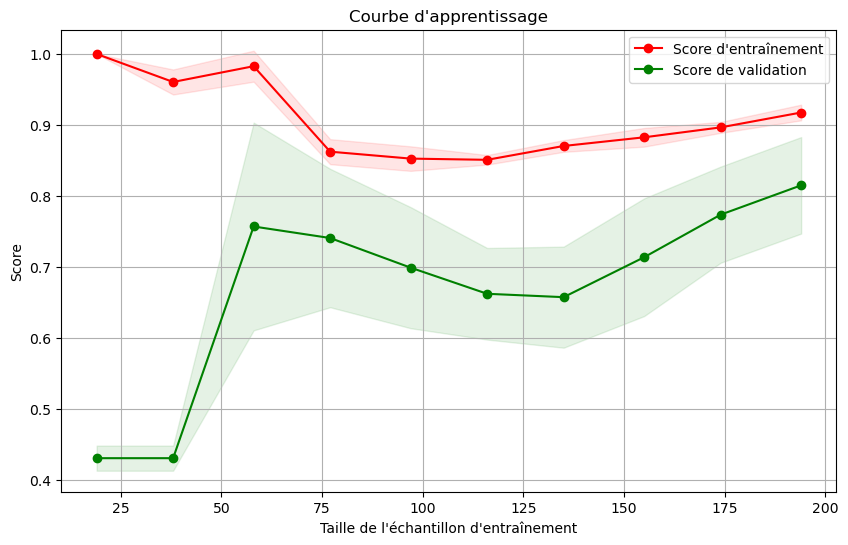

Scores par pli : [0.72727273 0.72727273 0.90909091 0.86363636 0.77272727 0.86363636
 0.9047619  0.76190476 0.80952381 0.85714286]
Score moyen    : 0.8197
Écart-type     : 0.0657


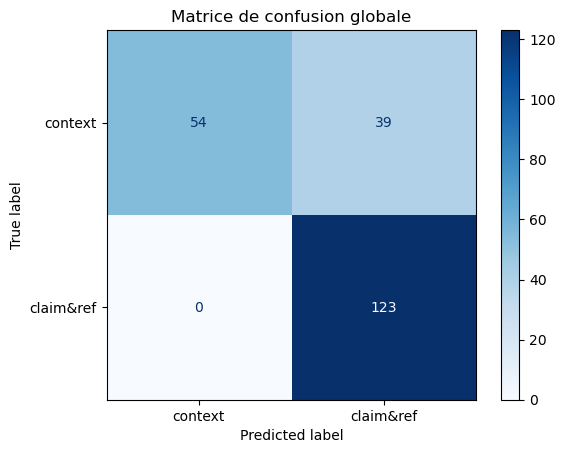

Accuracy: 0.8197
--------------------------------------------------------
Accuracy: 0.8464
F1-Score: 0.8508
Recall: 0.8571

=== Mots les plus importants par classe ===


,Word,Chi2
171,april,5.688873
2006,support,4.319918
1814,scienc,4.295587
1745,research,3.637859
892,grant,3.545842
1860,shape,3.313079
1205,lupu,3.141965
851,fund,2.976055
1446,on,2.729823
465,confer,2.727601


In [180]:
# Filtrer pour conserver une centaine de lignes équilibrées
#rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# Extract the 'label' column as the target
y_single = y['label']

# Apply RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=100 / len(y_single))
X_resampled, y_resampled = rus.fit_resample(X_vect, y_single)

# Apply ADASYN
ros = ADASYN(random_state=42, sampling_strategy=0.75438596499)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)



# Modèle choisi : Régression Logistique

#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.00125))
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))

#model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.00125)
#model = XGBClassifier(eval_metric='logloss')
#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42,C=0.001))
# Configuration des K-Folds
name1 = "context"
name2 ="claim&ref"
    
fitting_with_scaffold2(model,X_resampled,y_resampled,name1,name2)

## Séparation en 3 classes : CLAIM vs REF vs CONTEXT

In [268]:
import random  # Import the random module

# Étape 1 : Filtrer les tweets scientifiques
sci_df = df[df['science_related'] == 1].copy()

combo = ["remove_links", "remove_stopwords", "lemmatize_words", "stem_words"]

from nltk.corpus import wordnet

def get_synonyms(word):
    """Retrieve synonyms for a given word using WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(text, n=1):
    """Replace n random words in the text with their synonyms."""
    words = word_tokenize(text)
    new_words = words.copy()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = get_synonyms(word_to_replace)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == word_to_replace else word for word in new_words]
    return ' '.join(new_words)

def random_deletion(text, p=0.1):
    """Randomly delete words from the text with probability p."""
    words = word_tokenize(text)
    if len(words) == 1:  # Avoid deleting the only word
        return text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    return ' '.join(new_words)

def random_swap(text, n=1):
    """Randomly swap two words in the text n times."""
    words = word_tokenize(text)
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def random_insertion(text, n=1):
    """Randomly insert n words into the text."""
    words = word_tokenize(text)
    for _ in range(n):
        new_word = random.choice(list(stopwords.words('english')))
        idx = random.randint(0, len(words))
        words.insert(idx, new_word)
    return ' '.join(words)

# Apply data augmentation
sci_df['augmented_text'] = sci_df['text'].apply(lambda x: synonym_replacement(x, n=2))
sci_df['augmented_text'] = sci_df['augmented_text'].apply(lambda x: random_deletion(x, p=0.1))
sci_df['augmented_text'] = sci_df['augmented_text'].apply(lambda x: random_swap(x, n=2))
sci_df['augmented_text'] = sci_df['augmented_text'].apply(lambda x: random_insertion(x, n=2))

for transformation in combo:
    if transformation in transformations:
        sci_df['text'] = sci_df['text'].apply(transformations[transformation])
    else:
        print(f"Warning: {transformation} is not a valid transformation function.")
        


# Étape 2 : Préparer les données pour la classification
X = sci_df['text']
y = sci_df[['scientific_claim', 'scientific_reference', 'scientific_context']].idxmax(axis=1)

# Étape 3 : Vectorisation avec TF-IDF
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

Scores par pli : [0.89873418 0.84810127 0.87341772 0.86075949 0.86075949 0.89873418
 0.86075949 0.87341772 0.83544304 0.83333333]
Score moyen    : 0.8643
Écart-type     : 0.0215


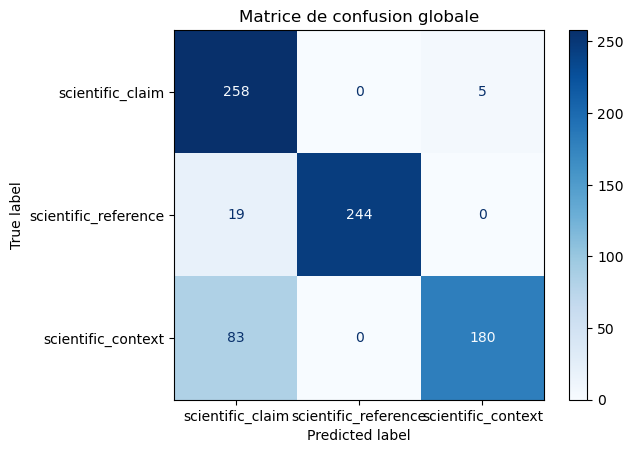

Accuracy : 0.8333
F1-Score : 0.8351
Recall   : 0.8333
Precision: 0.8734

Rapport de classification :
                      precision    recall  f1-score   support

    scientific_claim       0.68      0.96      0.79        26
  scientific_context       1.00      0.88      0.94        26
scientific_reference       0.94      0.65      0.77        26

            accuracy                           0.83        78
           macro avg       0.87      0.83      0.84        78
        weighted avg       0.87      0.83      0.84        78



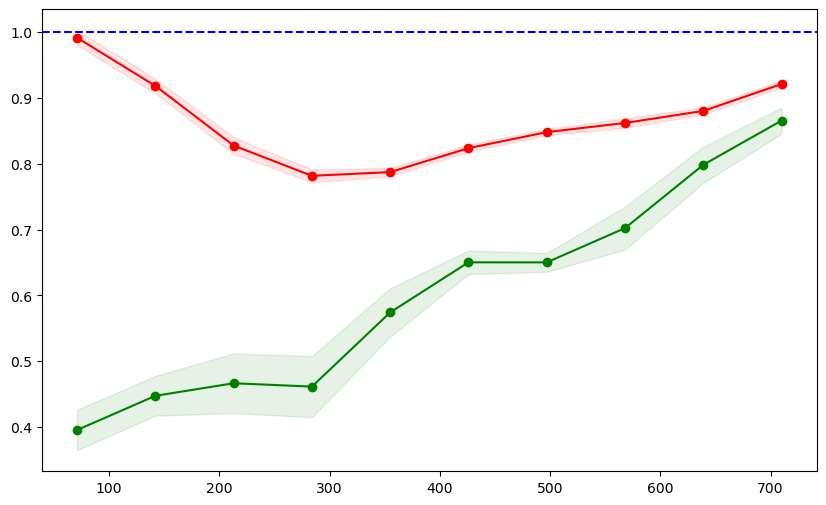

In [269]:
# Étape 4 : Convertir la cible en une seule colonne
# Utiliser idxmax pour obtenir la classe avec la valeur maximale
# Ensure y is a DataFrame before using idxmax
if isinstance(y, pd.DataFrame):
    y_single = y.idxmax(axis=1)
else:
    y_single = y  # If y is already a Series, use it directly

# Over-sampling avec SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vect, y_single)

# Étape 5 : Configuration des K-Folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Modèle choisi : Random Forest

model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
#model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,penalty='l2', C=0.00125))
#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42, C=0.1))
# Étape 6 : Validation croisée


cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

# Affichage des résultats de la validation croisée
print(f"Scores par pli : {cv_scores}")
print(f"Score moyen    : {cv_scores.mean():.4f}")
print(f"Écart-type     : {cv_scores.std():.4f}")

# Étape 7 : Entraînement final et évaluation
# Ensure consistent labels across all iterations
unique_labels = np.unique(y_resampled)
final_cm = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

for train_index, test_index in kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Add to the global confusion matrix using consistent labels
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    final_cm += cm

# Afficher la matrice de confusion finale
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=y_single.unique())
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion globale")
plt.show()

# Calculer et afficher les statistiques finales
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Afficher le rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


train_sizes, train_scores, test_scores = learning_curve(
    model, X_resampled, y_resampled, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Moyenne et écart-type des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r", label="Écart-type entraînement")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g", label="Écart-type validation")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")

# Ajouter une ligne pour indiquer que les scores d'entraînement sont toujours à 1
plt.axhline(y=1.0, color='b', linestyle='--', label="Score parfait (1.0)")



In [270]:
# Extraire les mots les plus importants par classe
feature_names = vectorizer.get_feature_names_out()
class_labels = y.unique()

# Calculer les scores chi2 pour chaque mot
chi2_scores, p_values = chi2(X_vect, y)

# Identifier les mots les plus discriminants pour chaque classe
for class_label in class_labels:
    print(f"Classe: {class_label}")
    class_indices = np.where(y == class_label)[0]
    class_chi2_scores = chi2_scores[class_indices]
    top_indices = class_chi2_scores.argsort()[-10:][::-1]  # Les 10 mots les plus discriminants
    top_words = [feature_names[i] for i in top_indices]
    print(f"Mots les plus discriminants: {', '.join(top_words)}\n")

Classe: scientific_claim
Mots les plus discriminants: awesom, anxieti, 789, asap, all, artoaj, adapt, among, 48, atrophi

Classe: scientific_reference
Mots les plus discriminants: 4k, 75, academi, academictwitt, abus, abstract, 093, 220, 500, 948

Classe: scientific_context
Mots les plus discriminants: 1930, 000, 107, 19, 13, 2012, 1815, 1twwwz9, 01, 093



Scores par pli : [0.93670886 0.94936709 0.89873418 0.93670886 0.96202532 0.96202532
 0.94936709 0.94936709 0.96202532 0.94871795]
Score moyen    : 0.9455
Écart-type     : 0.0179


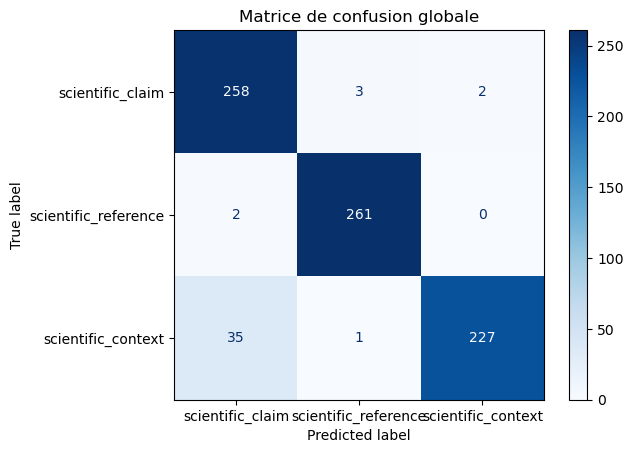

Accuracy : 0.9487
F1-Score : 0.9484
Recall   : 0.9487
Precision: 0.9556

Rapport de classification :
                      precision    recall  f1-score   support

    scientific_claim       0.87      1.00      0.93        26
  scientific_context       1.00      1.00      1.00        26
scientific_reference       1.00      0.85      0.92        26

            accuracy                           0.95        78
           macro avg       0.96      0.95      0.95        78
        weighted avg       0.96      0.95      0.95        78



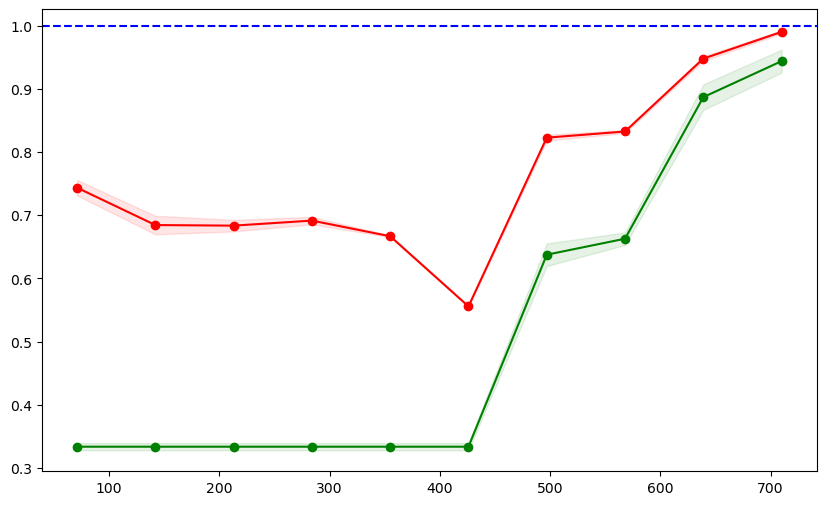

In [271]:
# Étape 4 : Over-sampling avec SMOTE
# Adjust the sampling strategy to ensure it does not exceed the original number of samples in any class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vect, y)

# Under-sampling to remove approximately 100 rows per class
# Ensure that the sampling strategy values are non-negative






# Étape 5 : Configuration des K-Folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Modèle choisi : Random Forest

param_grid = {
    'C': [0.1, 1, 10],  # Régularisation
    'kernel': ['linear', 'rbf'],  # Type de noyau
    'gamma': ['scale', 'auto']  # Paramètre gamma pour les noyaux non linéaires
}

#model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
#model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=5, random_state=42,penalty='l2', C=0.1))
model = OneVsRestClassifier(SVC(kernel='rbf',gamma=0.2, probability=True, random_state=42, C=0.000001))
# Étape 6 : Validation croisée




# Étape 7 : Entraînement final et évaluation
# Ensure consistent labels across all iterations
unique_labels = np.unique(y_resampled)
final_cm = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

for train_index, test_index in kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Add to the global confusion matrix using consistent labels
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    final_cm += cm


cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

# Affichage des résultats de la validation croisée
print(f"Scores par pli : {cv_scores}")
print(f"Score moyen    : {cv_scores.mean():.4f}")
print(f"Écart-type     : {cv_scores.std():.4f}")

# Afficher la matrice de confusion finale
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=y.unique())
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion globale")
plt.show()

# Calculer et afficher les statistiques finales
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Afficher le rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


train_sizes, train_scores, test_scores = learning_curve(
    model, X_resampled, y_resampled, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Moyenne et écart-type des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r", label="Écart-type entraînement")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g", label="Écart-type validation")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")

# Ajouter une ligne pour indiquer que les scores d'entraînement sont toujours à 1
plt.axhline(y=1.0, color='b', linestyle='--', label="Score parfait (1.0)")



=== Modèle : Logistic Regression ===
Scores par pli : [0.88607595 0.82278481 0.88607595 0.7721519  0.83544304 0.79746835
 0.79746835 0.83544304 0.81012658 0.82051282]
Score moyen    : 0.8264
Écart-type     : 0.0350


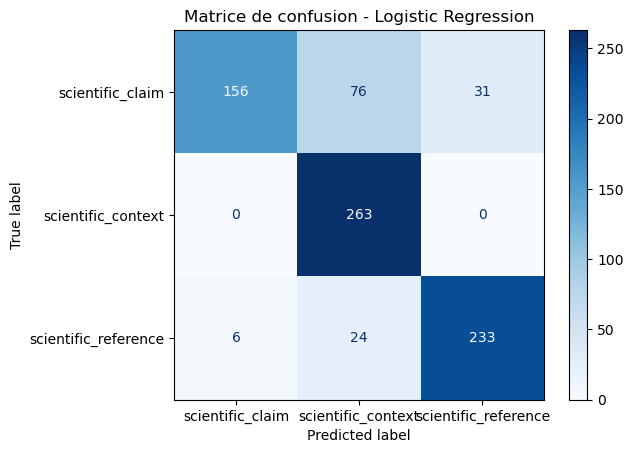

Accuracy : 0.8205
F1-Score : 0.8201
Recall   : 0.8205
Precision: 0.8611
=== Modèle : Linear SVM ===
Scores par pli : [0.98734177 0.94936709 0.93670886 0.93670886 0.98734177 0.98734177
 0.96202532 0.98734177 0.97468354 0.94871795]
Score moyen    : 0.9658
Écart-type     : 0.0205


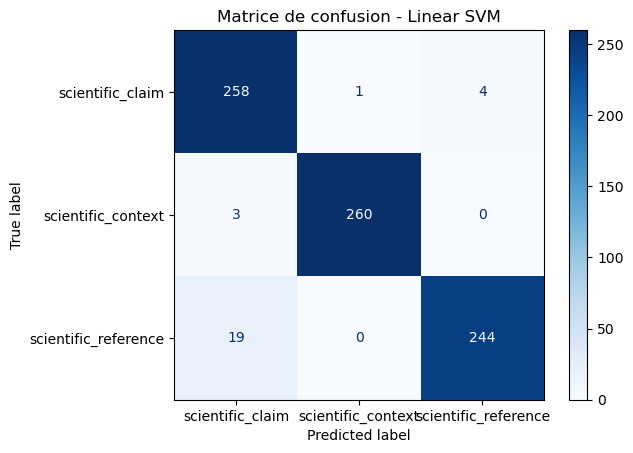

Accuracy : 0.9487
F1-Score : 0.9486
Recall   : 0.9487
Precision: 0.9504
=== Modèle : Naive Bayes ===
Scores par pli : [0.93670886 0.91139241 0.93670886 0.84810127 0.93670886 0.89873418
 0.89873418 0.97468354 0.91139241 0.92307692]
Score moyen    : 0.9176
Écart-type     : 0.0316


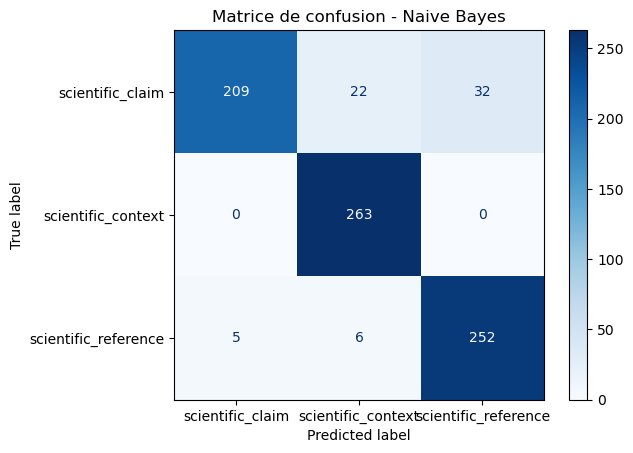

Accuracy : 0.9231
F1-Score : 0.9220
Recall   : 0.9231
Precision: 0.9228
=== Modèle : Gradient Boosting ===
Scores par pli : [0.88607595 0.86075949 0.88607595 0.87341772 0.88607595 0.87341772
 0.84810127 0.91139241 0.86075949 0.84615385]
Score moyen    : 0.8732
Écart-type     : 0.0190


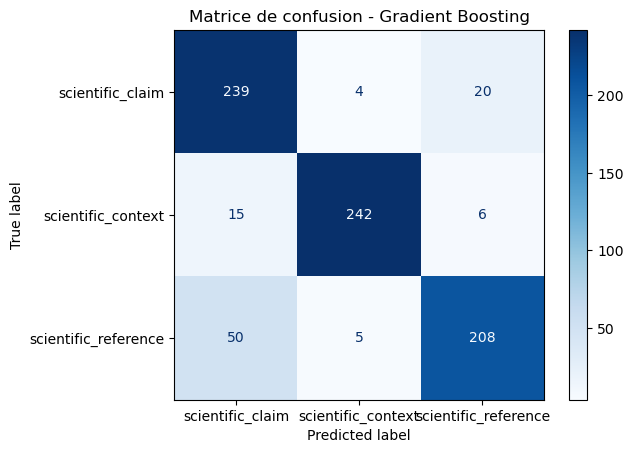

Accuracy : 0.8462
F1-Score : 0.8482
Recall   : 0.8462
Precision: 0.8556
=== Modèle : MLP Classifier ===
Scores par pli : [0.97468354 0.97468354 0.98734177 0.94936709 0.98734177 0.98734177
 0.98734177 1.         1.         0.98717949]
Score moyen    : 0.9835
Écart-type     : 0.0139


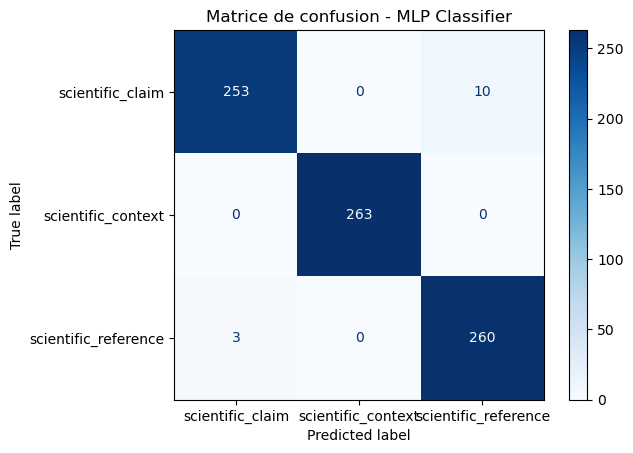

Accuracy : 0.9872
F1-Score : 0.9872
Recall   : 0.9872
Precision: 0.9877
=== Modèle : Random Forest ===
Scores par pli : [0.86075949 0.74683544 0.83544304 0.78481013 0.74683544 0.89873418
 0.79746835 0.73417722 0.78481013 0.74358974]
Score moyen    : 0.7933
Écart-type     : 0.0528


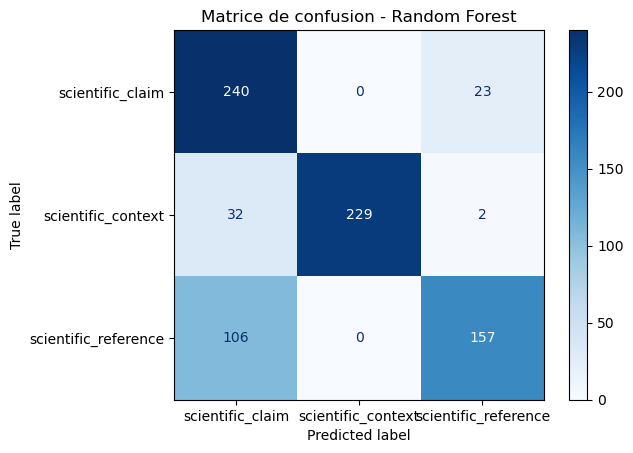

Accuracy : 0.7436
F1-Score : 0.7411
Recall   : 0.7436
Precision: 0.8304
=== Modèle : K-Nearest Neighbors ===
Scores par pli : [0.65822785 0.64556962 0.63291139 0.63291139 0.64556962 0.64556962
 0.64556962 0.65822785 0.64556962 0.62820513]
Score moyen    : 0.6438
Écart-type     : 0.0096


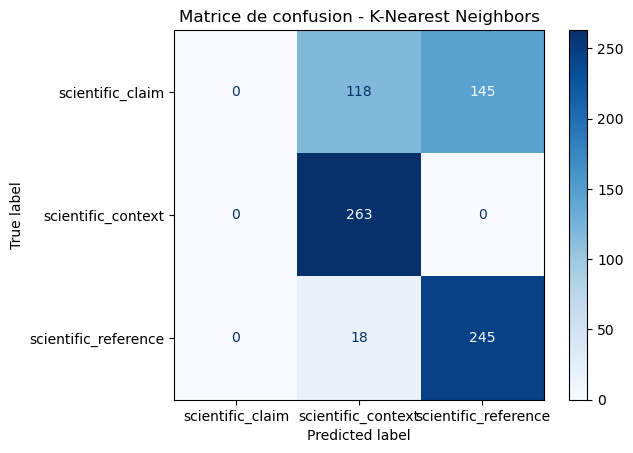

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy : 0.6282
F1-Score : 0.5026
Recall   : 0.6282
Precision: 0.4206
=== Modèle : Decision Tree ===
Scores par pli : [0.64556962 0.60759494 0.67088608 0.63291139 0.65822785 0.63291139
 0.6835443  0.67088608 0.62025316 0.65384615]
Score moyen    : 0.6477
Écart-type     : 0.0230


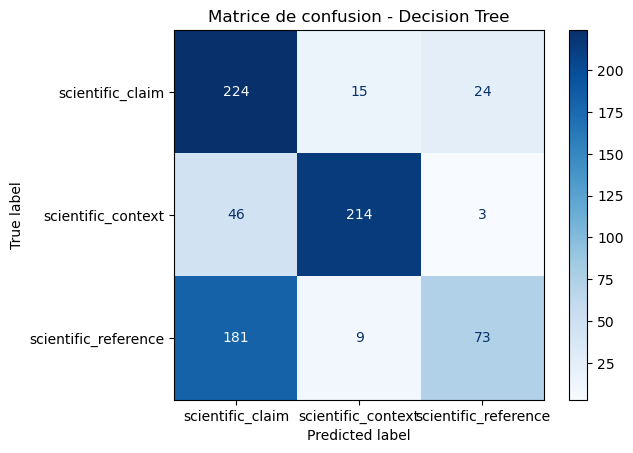

Accuracy : 0.6538
F1-Score : 0.6330
Recall   : 0.6538
Precision: 0.7591
=== Modèle : AdaBoost ===
Scores par pli : [0.79746835 0.63291139 0.69620253 0.73417722 0.6835443  0.84810127
 0.73417722 0.70886076 0.69620253 0.62820513]
Score moyen    : 0.7160
Écart-type     : 0.0642


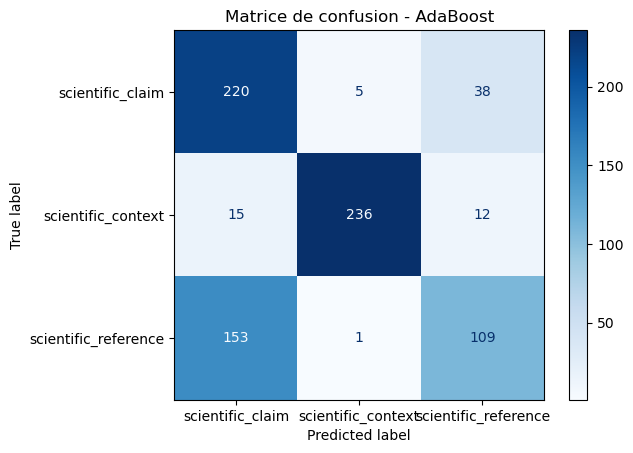

Accuracy : 0.6282
F1-Score : 0.6119
Recall   : 0.6282
Precision: 0.6345
=== Modèle : XGBoost ===


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\matth\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\matth\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\matth\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1640, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['scientific_claim' 'scientific_context' 'scientific_reference']


In [223]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# Étape 1 : Filtrer les données pour la catégorie SCI
sci_df = df[df['science_related'] == 1].copy()


combo = ["remove_links", "remove_stopwords", "lemmatize_words", "stem_words"]

for transformation in combo:
    if transformation in transformations:
        sci_df['text'] = sci_df['text'].apply(transformations[transformation])
    else:
        print(f"Warning: {transformation} is not a valid transformation function.")

# Étape 2 : Préparer les données pour la classification
X = sci_df['text']
y = sci_df[['scientific_claim', 'scientific_reference', 'scientific_context']].idxmax(axis=1)

# Étape 3 : Vectorisation avec TF-IDF
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

# Étape 4 : Over-sampling avec SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vect, y)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

# Liste des modèles à tester
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l2', C=0.0001, random_state=42),
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=1000, C=0.1, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Configuration des K-Folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Résultats
results = {}

for model_name, model in models.items():
    print(f"=== Modèle : {model_name} ===")
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')
    print(f"Scores par pli : {cv_scores}")
    print(f"Score moyen    : {cv_scores.mean():.4f}")
    print(f"Écart-type     : {cv_scores.std():.4f}")
    
    # Entraînement final et évaluation
    unique_labels = np.unique(y_resampled)
    final_cm = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)
    
    for train_index, test_index in kfold.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_index], X_resampled[test_index]
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Ajouter à la matrice de confusion globale
        cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
        final_cm += cm
    
    # Afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=unique_labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matrice de confusion - {model_name}")
    plt.show()
    
    # Calculer les statistiques finales
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy : {accuracy:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    
    # Stocker les résultats
    results[model_name] = {
        "accuracy": accuracy,
        "f1_score": f1,
        "recall": recall,
        "precision": precision
    }

# Afficher les résultats comparatifs
print("\n=== Résultats comparatifs ===")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

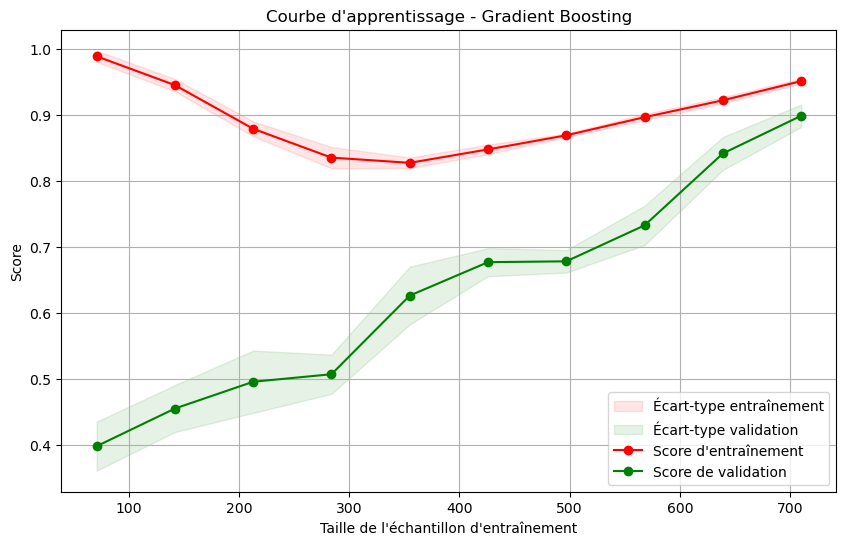

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random




# Vectorize the text data
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(sci_df['text'])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vect, y)

# Prepare the target variable
#y = sci_df[['scientific_claim', 'scientific_reference', 'scientific_context']].idxmax(axis=1)

# Use the vectorized data for training
#X_resampled = X_vect
#y_resampled = y

# Modèle choisi : Gradient Boosting
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42))
#model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=5, random_state=42,penalty='l2', C=0.01))
#model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42,C=0.000001))


# Configuration des K-Folds
kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Calculer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    model, X_resampled, y_resampled, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Moyenne et écart-type des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r", label="Écart-type entraînement")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g", label="Écart-type validation")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")

plt.title("Courbe d'apprentissage - Gradient Boosting")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()